# Problem Statement
  The task is to train a network to discriminate between sonar signals bounced off a metal cylinder(mines) and those bounced off a roughly cylindrical rock.

## Breakdown:

### Classification:
  This is a machine learning task where the goal is to assign data points to a specific category. In this case, the categories are "mine" and "rock".
### Sonar signals:
  These are sound waves used underwater for navigation and object detection.
### Metal cylinder(mines) vs. rock:
  The network needs to learn the subtle differences in the way sonar signals bounce off these two different materials, based on the 60 frequency band readings.

# Setup

## Install & Load

In [1]:
pip install ucimlrepo

In [2]:
# GENERAL
import sys
from packaging import version
import uuid

# DATA
import numpy as np
import pandas as pd

# Data Repository
from ucimlrepo import fetch_ucirepo

# VISULISATION
import seaborn as sns
import matplotlib.pyplot as plt

# MACHINE LEARNING

# Scikitlearn
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix, auc, \
                            log_loss, accuracy_score, make_scorer, average_precision_score
from sklearn.base import clone


# STATISTICS
from scipy.signal import find_peaks
from scipy.stats import boxcox, yeojohnson

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

# HYPERPARAMETER TUNNING
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

# Fundamental algorithms for scientific computing in Python
# Savitzky-Golay filter
from scipy.signal import savgol_filter


## Loading functions

In [3]:
def load_data_from_uci():
  # fetch dataset
  connectionist_bench_sonar_mines_vs_rocks = fetch_ucirepo(id=151)

  # data (as pandas dataframes)
  inputs = connectionist_bench_sonar_mines_vs_rocks.data.features
  targets = connectionist_bench_sonar_mines_vs_rocks.data.targets
  metadata = connectionist_bench_sonar_mines_vs_rocks.data.metadata
  varib_info = connectionist_bench_sonar_mines_vs_rocks.data.variables
  return inputs, targets, metadata, varib_info


# Understanding the data

In [4]:
inputs, targets, metadata, varib_info = load_data_from_uci()

In [5]:
inputs

Attribute1  Attribute2  Attribute3  Attribute4  Attribute5  Attribute6  \
0        0.0200      0.0371      0.0428      0.0207      0.0954      0.0986   
1        0.0453      0.0523      0.0843      0.0689      0.1183      0.2583   
2        0.0262      0.0582      0.1099      0.1083      0.0974      0.2280   
3        0.0100      0.0171      0.0623      0.0205      0.0205      0.0368   
4        0.0762      0.0666      0.0481      0.0394      0.0590      0.0649   
..          ...         ...         ...         ...         ...         ...   
203      0.0187      0.0346      0.0168      0.0177      0.0393      0.1630   
204      0.0323      0.0101      0.0298      0.0564      0.0760      0.0958   
205      0.0522      0.0437      0.0180      0.0292      0.0351      0.1171   
206      0.0303      0.0353      0.0490      0.0608      0.0167      0.1354   
207      0.0260      0.0363      0.0136      0.0272      0.0214      0.0338   

     Attribute7  Attribute8  Attribute9  Attribute10  ...  Attribute51  \
0        0.1539      0.1601      0.3109       0.2111  ...       0.0232   
1        0.2156      0.3481      0.3337       0.2872  ...       0.0125   
2        0.2431      0.3771      0.5598       0.6194  ...       0.0033   
3        0.1098      0.1276      0.0598       0.1264  ...       0.0241   
4        0.1209      0.2467      0.3564       0.4459  ...       0.0156   
..          ...         ...         ...          ...  ...          ...   
203      0.2028      0.1694      0.2328       0.2684  ...       0.0203   
204      0.0990      0.1018      0.1030       0.2154  ...       0.0051   
205      0.1257      0.1178      0.1258       0.2529  ...       0.0155   
206      0.1465      0.1123      0.1945       0.2354  ...       0.0042   
207      0.0655      0.1400      0.1843       0.2354  ...       0.0181   

     Attribute52  Attribute53  Attribute54  Attribute55  Attribute56  \
0         0.0027       0.0065       0.0159       0.0072       0.0167   
1         0.0084       0.0089       0.0048       0.0094       0.0191   
2         0.0232       0.0166       0.0095       0.0180       0.0244   
3         0.0121       0.0036       0.0150       0.0085       0.0073   
4         0.0031       0.0054       0.0105       0.0110       0.0015   
..           ...          ...          ...          ...          ...   
203       0.0116       0.0098       0.0199       0.0033       0.0101   
204       0.0061       0.0093       0.0135       0.0063       0.0063   
205       0.0160       0.0029       0.0051       0.0062       0.0089   
206       0.0086       0.0046       0.0126       0.0036       0.0035   
207       0.0146       0.0129       0.0047       0.0039       0.0061   

     Attribute57  Attribute58  Attribute59  Attribute60  
0         0.0180       0.0084       0.0090       0.0032  
1         0.0140       0.0049       0.0052       0.0044  
2         0.0316       0.0164       0.0095       0.0078  
3         0.0050       0.0044       0.0040       0.0117  
4         0.0072       0.0048       0.0107       0.0094  
..           ...          ...          ...          ...  
203       0.0065       0.0115       0.0193       0.0157  
204       0.0034       0.0032       0.0062       0.0067  
205       0.0140       0.0138       0.0077       0.0031  
206       0.0034       0.0079       0.0036       0.0048  
207       0.0040       0.0036       0.0061       0.0115  

[208 rows x 60 columns]

In [6]:
targets

class
0       R
1       R
2       R
3       R
4       R
..    ...
203     M
204     M
205     M
206     M
207     M

[208 rows x 1 columns]

In [7]:
targets.value_counts()

class
M        111
R         97
Name: count, dtype: int64

In [8]:
targets.value_counts(normalize=True)

class
M        0.533654
R        0.466346
Name: proportion, dtype: float64

In [9]:
targets.columns

Index(['class'], dtype='object')

In [10]:
targets['class'].value_counts(normalize=True)

class
M    0.533654
R    0.466346
Name: proportion, dtype: float64

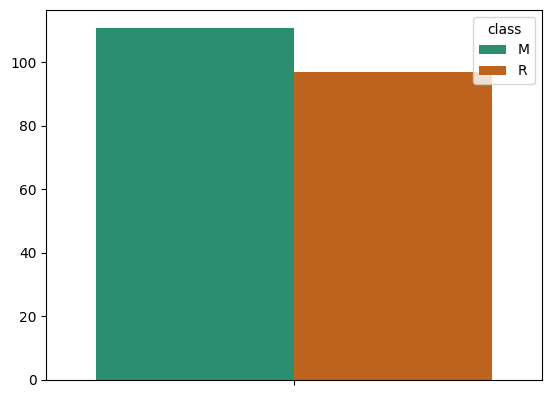

In [11]:
sns.barplot(hue=targets['class'].value_counts().index, y = targets['class'].value_counts().values, palette='Dark2');

In [12]:
inputs.describe().T[['min', 'max', 'mean', 'std']]

min     max      mean       std
Attribute1   0.0015  0.1371  0.029164  0.022991
Attribute2   0.0006  0.2339  0.038437  0.032960
Attribute3   0.0015  0.3059  0.043832  0.038428
Attribute4   0.0058  0.4264  0.053892  0.046528
Attribute5   0.0067  0.4010  0.075202  0.055552
Attribute6   0.0102  0.3823  0.104570  0.059105
Attribute7   0.0033  0.3729  0.121747  0.061788
Attribute8   0.0055  0.4590  0.134799  0.085152
Attribute9   0.0075  0.6828  0.178003  0.118387
Attribute10  0.0113  0.7106  0.208259  0.134416
Attribute11  0.0289  0.7342  0.236013  0.132705
Attribute12  0.0236  0.7060  0.250221  0.140072
Attribute13  0.0184  0.7131  0.273305  0.140962
Attribute14  0.0273  0.9970  0.296568  0.164474
Attribute15  0.0031  1.0000  0.320201  0.205427
Attribute16  0.0162  0.9988  0.378487  0.232650
Attribute17  0.0349  1.0000  0.415983  0.263677
Attribute18  0.0375  1.0000  0.452318  0.261529
Attribute19  0.0494  1.0000  0.504812  0.257988
Attribute20  0.0656  1.0000  0.563047  0.262653
Attribute21  0.0512  1.0000  0.609060  0.257818
Attribute22  0.0219  1.0000  0.624275  0.255883
Attribute23  0.0563  1.0000  0.646975  0.250175
Attribute24  0.0239  1.0000  0.672654  0.239116
Attribute25  0.0240  1.0000  0.675424  0.244926
Attribute26  0.0921  1.0000  0.699866  0.237228
Attribute27  0.0481  1.0000  0.702155  0.245657
Attribute28  0.0284  1.0000  0.694024  0.237189
Attribute29  0.0144  1.0000  0.642074  0.240250
Attribute30  0.0613  1.0000  0.580928  0.220749
Attribute31  0.0482  0.9657  0.504475  0.213992
Attribute32  0.0404  0.9306  0.439040  0.213237
Attribute33  0.0477  1.0000  0.417220  0.206513
Attribute34  0.0212  0.9647  0.403233  0.231242
Attribute35  0.0223  1.0000  0.392571  0.259132
Attribute36  0.0080  1.0000  0.384848  0.264121
Attribute37  0.0351  0.9497  0.363807  0.239912
Attribute38  0.0383  1.0000  0.339657  0.212973
Attribute39  0.0371  0.9857  0.325800  0.199075
Attribute40  0.0117  0.9297  0.311207  0.178662
Attribute41  0.0360  0.8995  0.289252  0.171111
Attribute42  0.0056  0.8246  0.278293  0.168728
Attribute43  0.0000  0.7733  0.246542  0.138993
Attribute44  0.0000  0.7762  0.214075  0.133291
Attribute45  0.0000  0.7034  0.197232  0.151628
Attribute46  0.0000  0.7292  0.160631  0.133938
Attribute47  0.0000  0.5522  0.122453  0.086953
Attribute48  0.0000  0.3339  0.091424  0.062417
Attribute49  0.0000  0.1981  0.051929  0.035954
Attribute50  0.0000  0.0825  0.020424  0.013665
Attribute51  0.0000  0.1004  0.016069  0.012008
Attribute52  0.0008  0.0709  0.013420  0.009634
Attribute53  0.0005  0.0390  0.010709  0.007060
Attribute54  0.0010  0.0352  0.010941  0.007301
Attribute55  0.0006  0.0447  0.009290  0.007088
Attribute56  0.0004  0.0394  0.008222  0.005736
Attribute57  0.0003  0.0355  0.007820  0.005785
Attribute58  0.0003  0.0440  0.007949  0.006470
Attribute59  0.0001  0.0364  0.007941  0.006181
Attribute60  0.0006  0.0439  0.006507  0.005031

since on the site https://archive.ics.uci.edu/dataset/151/connectionist+bench+sonar+mines+vs+rocks (where data is downloaded from) it is mentioned that there are no missing values, we are skipping that step. But it is a good practice to reconfirm


In [13]:
df = pd.concat([inputs, targets], axis = 1)
df.isna().sum()

Attribute1     0
Attribute2     0
Attribute3     0
Attribute4     0
Attribute5     0
              ..
Attribute57    0
Attribute58    0
Attribute59    0
Attribute60    0
class          0
Length: 61, dtype: int64

In [14]:
df.groupby('class').mean().T

class               M         R
Attribute1   0.034989  0.022498
Attribute2   0.045544  0.030303
Attribute3   0.050720  0.035951
Attribute4   0.064768  0.041447
Attribute5   0.086715  0.062028
Attribute6   0.111864  0.096224
Attribute7   0.128359  0.114180
Attribute8   0.149832  0.117596
Attribute9   0.213492  0.137392
Attribute10  0.251022  0.159325
Attribute11  0.289581  0.174713
Attribute12  0.301459  0.191589
Attribute13  0.314426  0.226249
Attribute14  0.320692  0.268963
Attribute15  0.331182  0.307636
Attribute16  0.380999  0.375611
Attribute17  0.415007  0.417100
Attribute18  0.455882  0.448240
Attribute19  0.538062  0.466762
Attribute20  0.617941  0.500229
Attribute21  0.667426  0.542270
Attribute22  0.672325  0.569290
Attribute23  0.676701  0.612959
Attribute24  0.689165  0.653761
Attribute25  0.681204  0.668809
Attribute26  0.706075  0.692762
Attribute27  0.714754  0.687737
Attribute28  0.712269  0.673145
Attribute29  0.650283  0.632680
Attribute30  0.581796  0.579934
Attribute31  0.482378  0.529762
Attribute32  0.428049  0.451619
Attribute33  0.396577  0.440841
Attribute34  0.366140  0.445680
Attribute35  0.337553  0.455530
Attribute36  0.318553  0.460710
Attribute37  0.317034  0.417330
Attribute38  0.331608  0.348868
Attribute39  0.336365  0.313709
Attribute40  0.305221  0.318057
Attribute41  0.292594  0.285428
Attribute42  0.300975  0.252338
Attribute43  0.276883  0.211822
Attribute44  0.248106  0.175132
Attribute45  0.245225  0.142312
Attribute46  0.198804  0.116949
Attribute47  0.146917  0.094458
Attribute48  0.110594  0.069488
Attribute49  0.063708  0.038449
Attribute50  0.022721  0.017796
Attribute51  0.019352  0.012311
Attribute52  0.016014  0.010453
Attribute53  0.011643  0.009640
Attribute54  0.012185  0.009518
Attribute55  0.009923  0.008567
Attribute56  0.008914  0.007430
Attribute57  0.007825  0.007814
Attribute58  0.009060  0.006677
Attribute59  0.008695  0.007078
Attribute60  0.006930  0.006024

# Data Preparation

In [15]:
df.head()

Attribute1  Attribute2  Attribute3  Attribute4  Attribute5  Attribute6  \
0      0.0200      0.0371      0.0428      0.0207      0.0954      0.0986   
1      0.0453      0.0523      0.0843      0.0689      0.1183      0.2583   
2      0.0262      0.0582      0.1099      0.1083      0.0974      0.2280   
3      0.0100      0.0171      0.0623      0.0205      0.0205      0.0368   
4      0.0762      0.0666      0.0481      0.0394      0.0590      0.0649   

   Attribute7  Attribute8  Attribute9  Attribute10  ...  Attribute52  \
0      0.1539      0.1601      0.3109       0.2111  ...       0.0027   
1      0.2156      0.3481      0.3337       0.2872  ...       0.0084   
2      0.2431      0.3771      0.5598       0.6194  ...       0.0232   
3      0.1098      0.1276      0.0598       0.1264  ...       0.0121   
4      0.1209      0.2467      0.3564       0.4459  ...       0.0031   

   Attribute53  Attribute54  Attribute55  Attribute56  Attribute57  \
0       0.0065       0.0159       0.0072       0.0167       0.0180   
1       0.0089       0.0048       0.0094       0.0191       0.0140   
2       0.0166       0.0095       0.0180       0.0244       0.0316   
3       0.0036       0.0150       0.0085       0.0073       0.0050   
4       0.0054       0.0105       0.0110       0.0015       0.0072   

   Attribute58  Attribute59  Attribute60  class  
0       0.0084       0.0090       0.0032      R  
1       0.0049       0.0052       0.0044      R  
2       0.0164       0.0095       0.0078      R  
3       0.0044       0.0040       0.0117      R  
4       0.0048       0.0107       0.0094      R  

[5 rows x 61 columns]

In [16]:
df['uuid'] = [uuid.uuid4() for _ in range(len(df))]
df.head()

Attribute1  Attribute2  Attribute3  Attribute4  Attribute5  Attribute6  \
0      0.0200      0.0371      0.0428      0.0207      0.0954      0.0986   
1      0.0453      0.0523      0.0843      0.0689      0.1183      0.2583   
2      0.0262      0.0582      0.1099      0.1083      0.0974      0.2280   
3      0.0100      0.0171      0.0623      0.0205      0.0205      0.0368   
4      0.0762      0.0666      0.0481      0.0394      0.0590      0.0649   

   Attribute7  Attribute8  Attribute9  Attribute10  ...  Attribute53  \
0      0.1539      0.1601      0.3109       0.2111  ...       0.0065   
1      0.2156      0.3481      0.3337       0.2872  ...       0.0089   
2      0.2431      0.3771      0.5598       0.6194  ...       0.0166   
3      0.1098      0.1276      0.0598       0.1264  ...       0.0036   
4      0.1209      0.2467      0.3564       0.4459  ...       0.0054   

   Attribute54  Attribute55  Attribute56  Attribute57  Attribute58  \
0       0.0159       0.0072       0.0167       0.0180       0.0084   
1       0.0048       0.0094       0.0191       0.0140       0.0049   
2       0.0095       0.0180       0.0244       0.0316       0.0164   
3       0.0150       0.0085       0.0073       0.0050       0.0044   
4       0.0105       0.0110       0.0015       0.0072       0.0048   

   Attribute59  Attribute60  class                                  uuid  
0       0.0090       0.0032      R  ae5b49f9-ce28-4a4d-bdb5-7bb58f90127c  
1       0.0052       0.0044      R  256ef016-b484-4fd3-8b0a-31af188c6023  
2       0.0095       0.0078      R  3d5fb30f-e8a9-4776-bb8f-cd30b712ec26  
3       0.0040       0.0117      R  10e02361-7cc8-4124-89fc-31187ef2cadd  
4       0.0107       0.0094      R  d0b2e3db-aedd-44d1-98d7-fd4b8699329c  

[5 rows x 62 columns]

## creating train & test datasets

In [17]:
train_df, test_df = train_test_split(df,
                                     test_size = 0.2,
                                     stratify=df['class'],
                                     random_state = 54)

train_df.shape, test_df.shape

((166, 62), (42, 62))

In [18]:
train_df.head()

Attribute1  Attribute2  Attribute3  Attribute4  Attribute5  Attribute6  \
25       0.0201      0.0026      0.0138      0.0062      0.0133      0.0151   
200      0.0131      0.0387      0.0329      0.0078      0.0721      0.1341   
150      0.0209      0.0278      0.0115      0.0445      0.0427      0.0766   
88       0.0274      0.0242      0.0621      0.0560      0.1129      0.0973   
162      0.0217      0.0152      0.0346      0.0346      0.0484      0.0526   

     Attribute7  Attribute8  Attribute9  Attribute10  ...  Attribute53  \
25       0.0541      0.0210      0.0505       0.1097  ...       0.0070   
200      0.1626      0.1902      0.2610       0.3193  ...       0.0076   
150      0.1458      0.1430      0.1894       0.1853  ...       0.0014   
88       0.1823      0.1745      0.1440       0.1808  ...       0.0108   
162      0.0773      0.0862      0.1451       0.2110  ...       0.0067   

     Attribute54  Attribute55  Attribute56  Attribute57  Attribute58  \
25        0.0063       0.0030       0.0011       0.0007       0.0024   
200       0.0032       0.0037       0.0071       0.0040       0.0009   
150       0.0049       0.0039       0.0029       0.0078       0.0047   
88        0.0085       0.0047       0.0074       0.0104       0.0161   
162       0.0011       0.0026       0.0049       0.0029       0.0022   

     Attribute59  Attribute60  class                                  uuid  
25        0.0057       0.0044      R  a81a21a1-3a74-4d67-94e5-95070c28f3ce  
200       0.0015       0.0085      M  46a3ff0e-b342-413c-8e14-2ce98019ff77  
150       0.0021       0.0011      M  55ccead9-5b9c-4cd1-80ca-5c528aa880fa  
88        0.0220       0.0173      R  b87d03e9-671b-4824-82e1-841aba99a8c6  
162       0.0022       0.0032      M  3b7b5618-41e9-47c0-81ed-9e20567e0886  

[5 rows x 62 columns]

In [19]:
train_df['class'].value_counts(normalize=True)

class
M    0.536145
R    0.463855
Name: proportion, dtype: float64

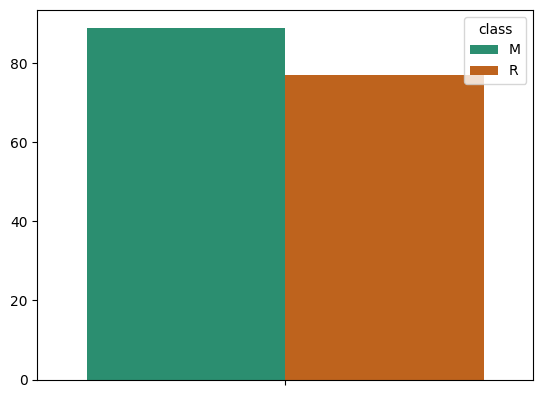

In [20]:
sns.barplot(hue=train_df['class'].value_counts().index, y = train_df['class'].value_counts().values, palette='Dark2');

In [21]:
train_df.columns

Index(['Attribute1', 'Attribute2', 'Attribute3', 'Attribute4', 'Attribute5',
       'Attribute6', 'Attribute7', 'Attribute8', 'Attribute9', 'Attribute10',
       'Attribute11', 'Attribute12', 'Attribute13', 'Attribute14',
       'Attribute15', 'Attribute16', 'Attribute17', 'Attribute18',
       'Attribute19', 'Attribute20', 'Attribute21', 'Attribute22',
       'Attribute23', 'Attribute24', 'Attribute25', 'Attribute26',
       'Attribute27', 'Attribute28', 'Attribute29', 'Attribute30',
       'Attribute31', 'Attribute32', 'Attribute33', 'Attribute34',
       'Attribute35', 'Attribute36', 'Attribute37', 'Attribute38',
       'Attribute39', 'Attribute40', 'Attribute41', 'Attribute42',
       'Attribute43', 'Attribute44', 'Attribute45', 'Attribute46',
       'Attribute47', 'Attribute48', 'Attribute49', 'Attribute50',
       'Attribute51', 'Attribute52', 'Attribute53', 'Attribute54',
       'Attribute55', 'Attribute56', 'Attribute57', 'Attribute58',
       'Attribute59', 'Attribute60', 'cla

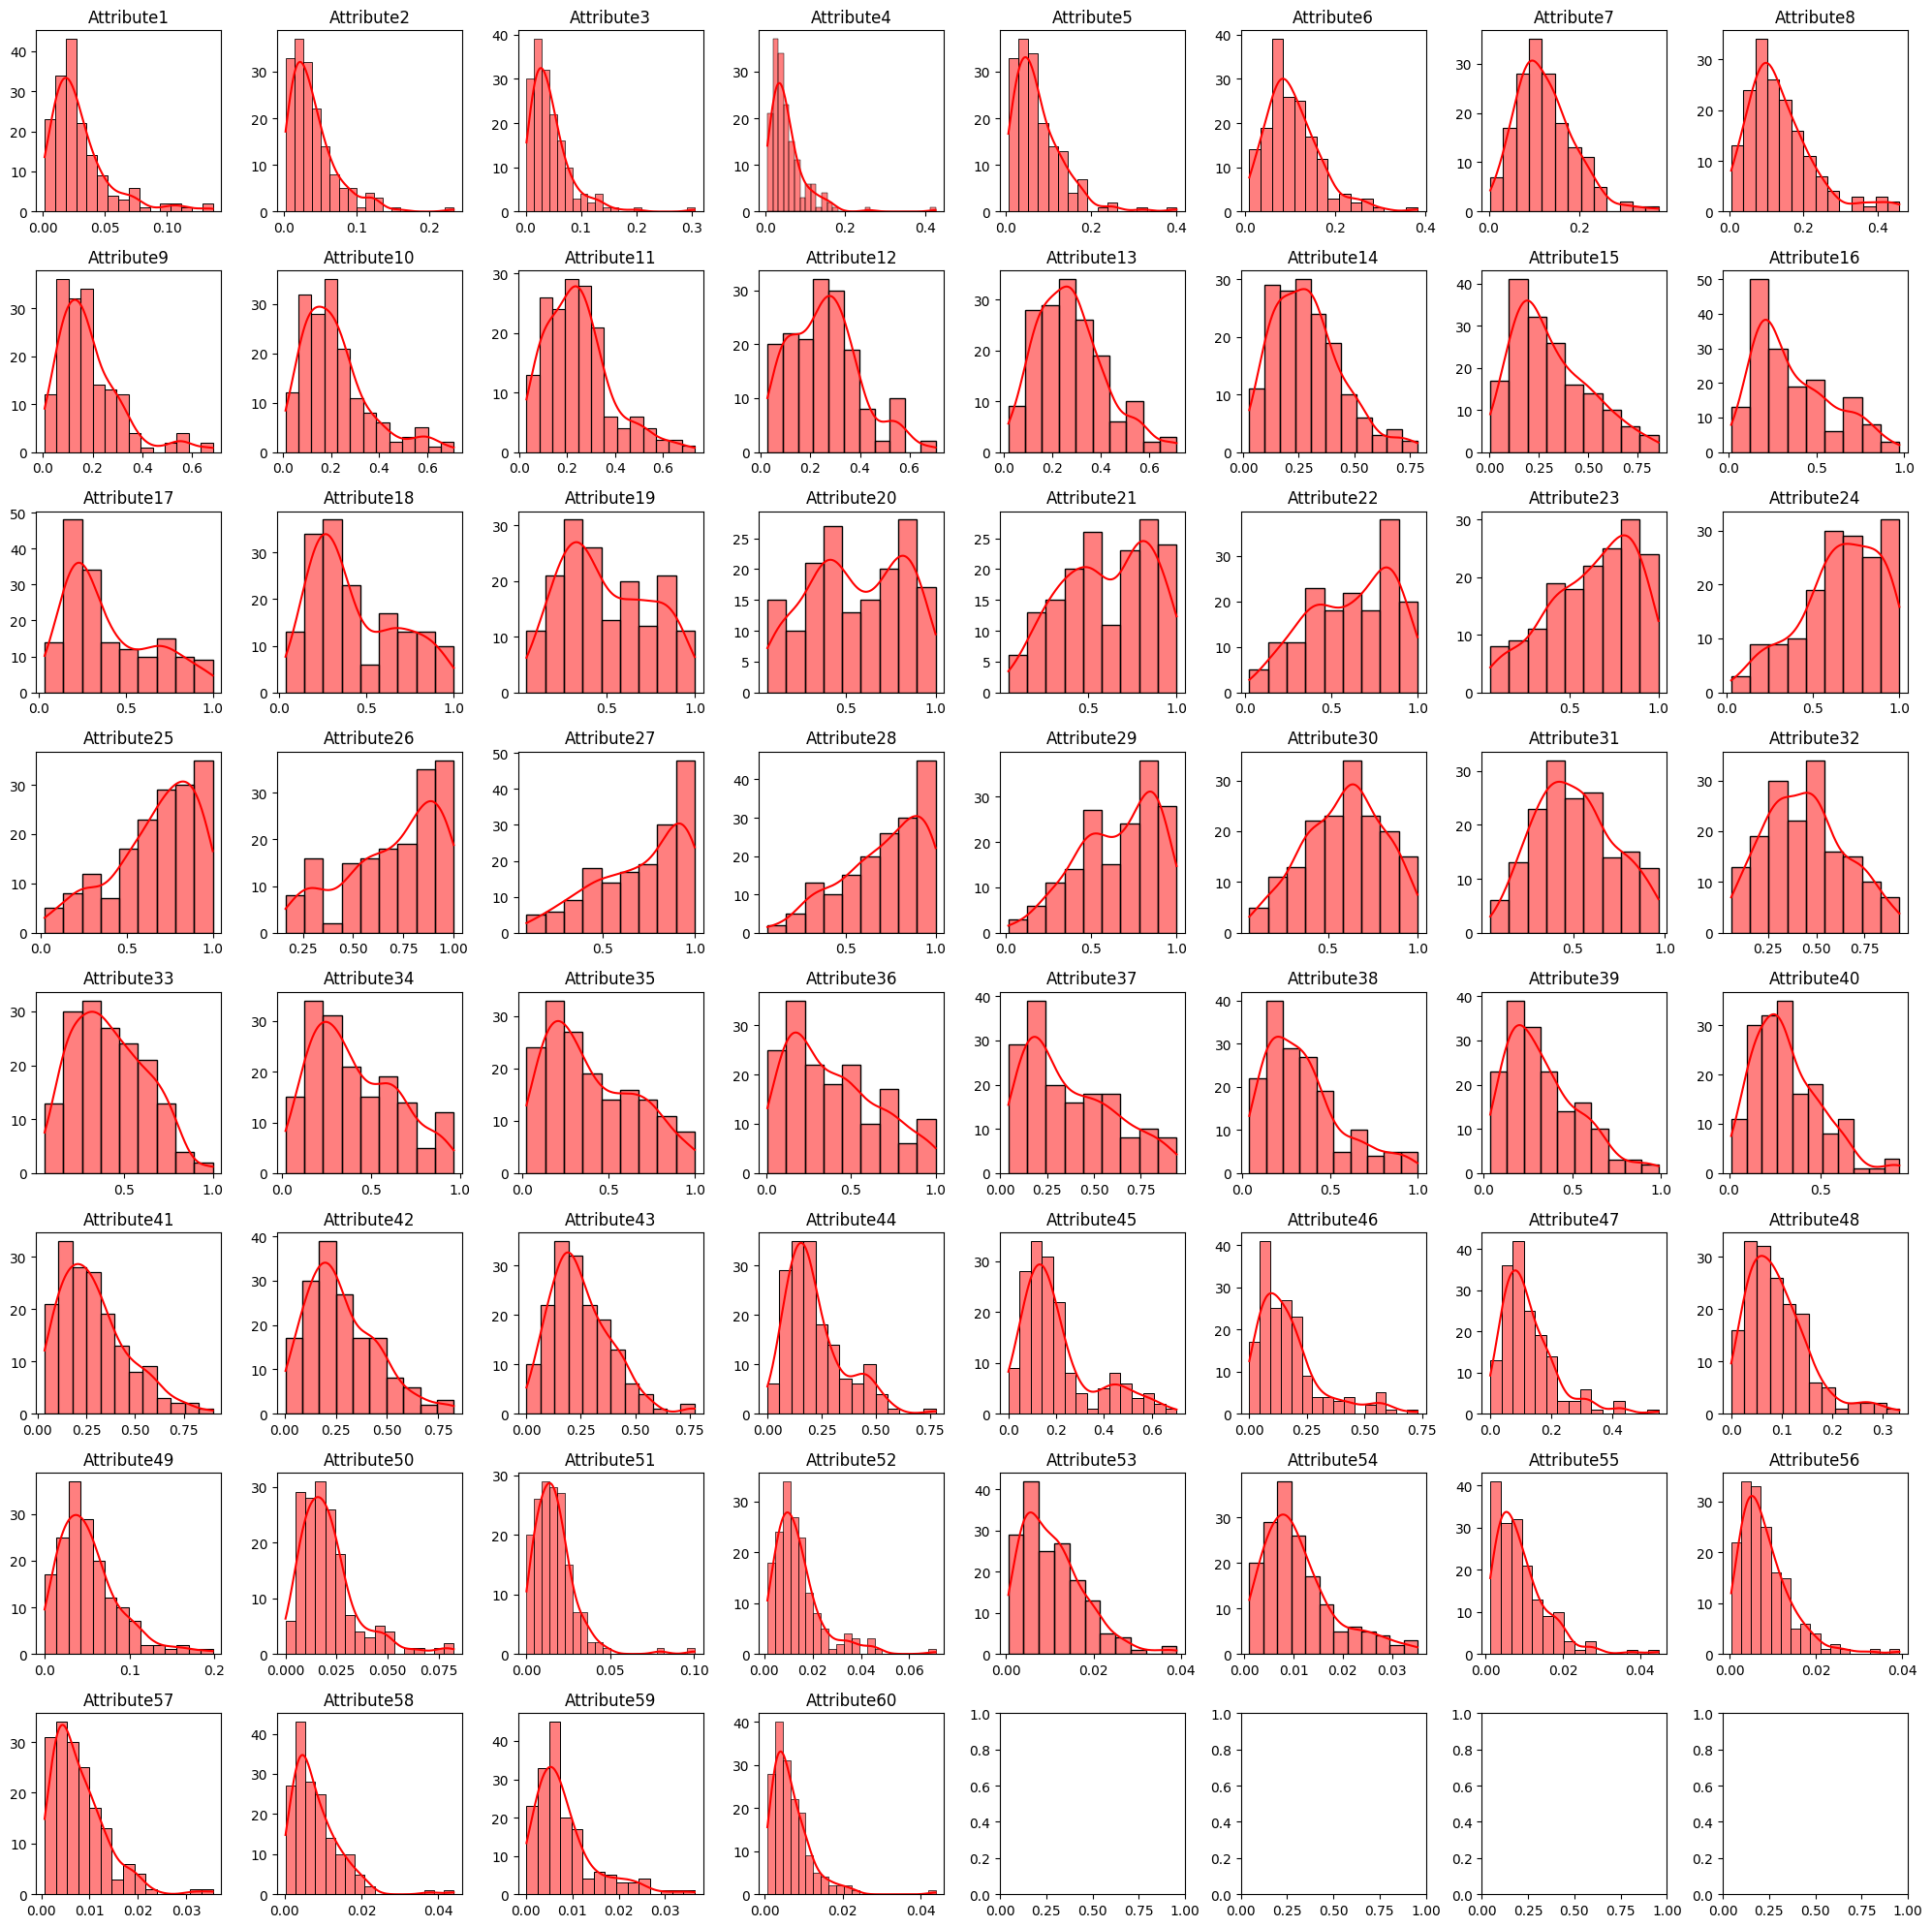

In [22]:
cols = train_df.columns.drop(['class', 'uuid'])
x = 0
fig, axes = plt.subplots(8, 8, figsize=(20, 20))

for i in cols:
  row = x // 8
  col = x % 8
  sns.histplot(train_df[i], color='red', kde=True, ax=axes[row, col]);
  x += 1
  axes[row, col].set_title(i)
  axes[row, col].set_xlabel('')
  axes[row, col].set_ylabel('')

plt.tight_layout()
plt.show()

# Feature engineering

## generating X & y

In [23]:
def make_x_y(df, target_col, drop_col):

  df = df.drop(columns = [drop_col])
  X = df.drop(columns = [target_col])
  y = df[target_col]
  return X,y


# Determine X and y
train_X, train_y = make_x_y(train_df, 'class', 'uuid')
test_X, test_y = make_x_y(test_df, 'class', 'uuid')

In [24]:
train_X.head()

Attribute1  Attribute2  Attribute3  Attribute4  Attribute5  Attribute6  \
25       0.0201      0.0026      0.0138      0.0062      0.0133      0.0151   
200      0.0131      0.0387      0.0329      0.0078      0.0721      0.1341   
150      0.0209      0.0278      0.0115      0.0445      0.0427      0.0766   
88       0.0274      0.0242      0.0621      0.0560      0.1129      0.0973   
162      0.0217      0.0152      0.0346      0.0346      0.0484      0.0526   

     Attribute7  Attribute8  Attribute9  Attribute10  ...  Attribute51  \
25       0.0541      0.0210      0.0505       0.1097  ...       0.0072   
200      0.1626      0.1902      0.2610       0.3193  ...       0.0137   
150      0.1458      0.1430      0.1894       0.1853  ...       0.0133   
88       0.1823      0.1745      0.1440       0.1808  ...       0.0255   
162      0.0773      0.0862      0.1451       0.2110  ...       0.0205   

     Attribute52  Attribute53  Attribute54  Attribute55  Attribute56  \
25        0.0108       0.0070       0.0063       0.0030       0.0011   
200       0.0150       0.0076       0.0032       0.0037       0.0071   
150       0.0096       0.0014       0.0049       0.0039       0.0029   
88        0.0113       0.0108       0.0085       0.0047       0.0074   
162       0.0123       0.0067       0.0011       0.0026       0.0049   

     Attribute57  Attribute58  Attribute59  Attribute60  
25        0.0007       0.0024       0.0057       0.0044  
200       0.0040       0.0009       0.0015       0.0085  
150       0.0078       0.0047       0.0021       0.0011  
88        0.0104       0.0161       0.0220       0.0173  
162       0.0029       0.0022       0.0022       0.0032  

[5 rows x 60 columns]

In [25]:
train_y.head()

25     R
200    M
150    M
88     R
162    M
Name: class, dtype: object

In [26]:
train_y.value_counts()

class
M    89
R    77
Name: count, dtype: int64

## feature transformation

Most ML algorithms assume the distribution of the data to be "Normal" but a normal distribution of the data can not be desired every time with every type of dataset, which means the data which is not normally distributed needs preprocessing and cleaning before applying the machine learning algorithm to it.

visit the following url "https://www.geeksforgeeks.org/feature-transformation-techniques-in-machine-learning/" to understand why we considering the below techniques

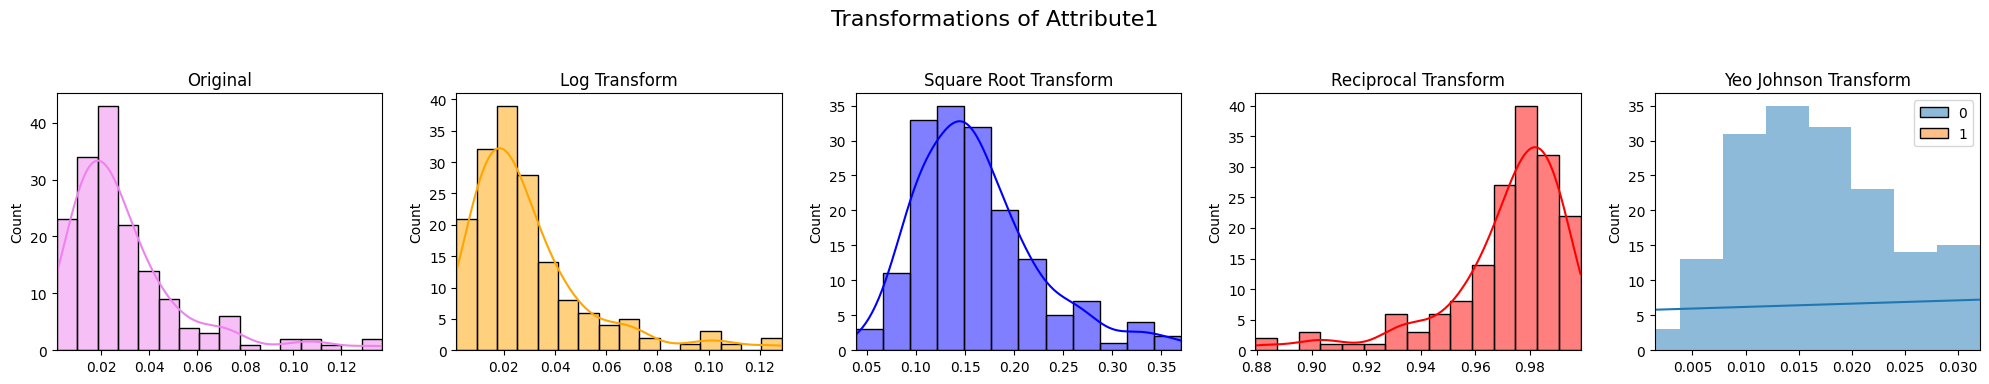

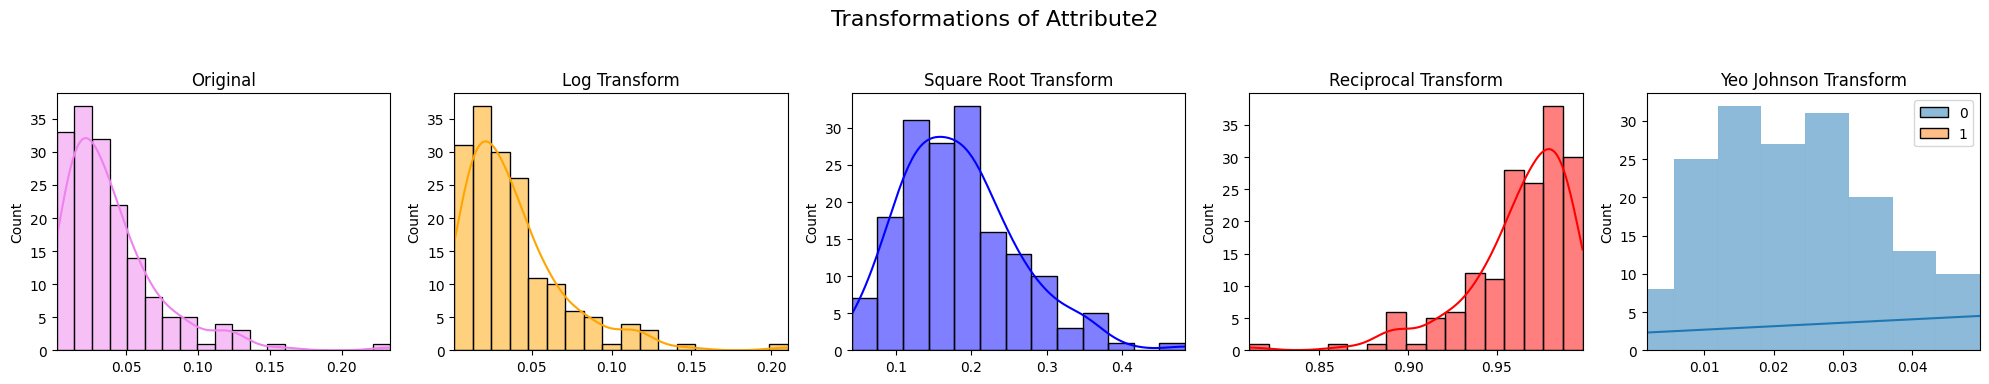

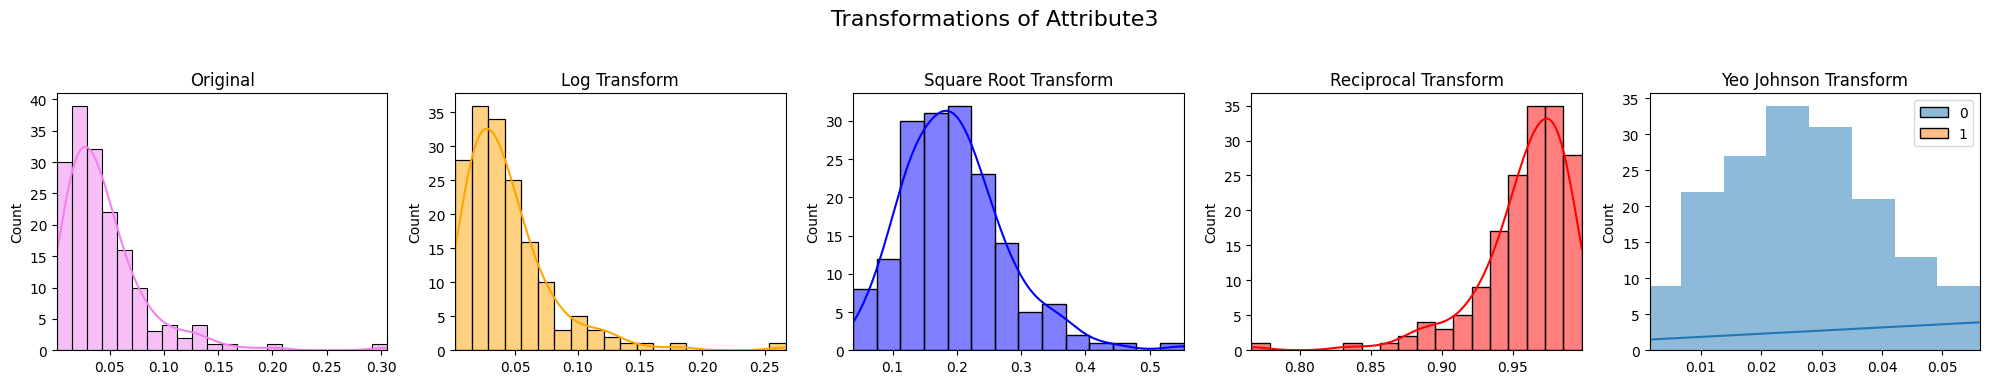

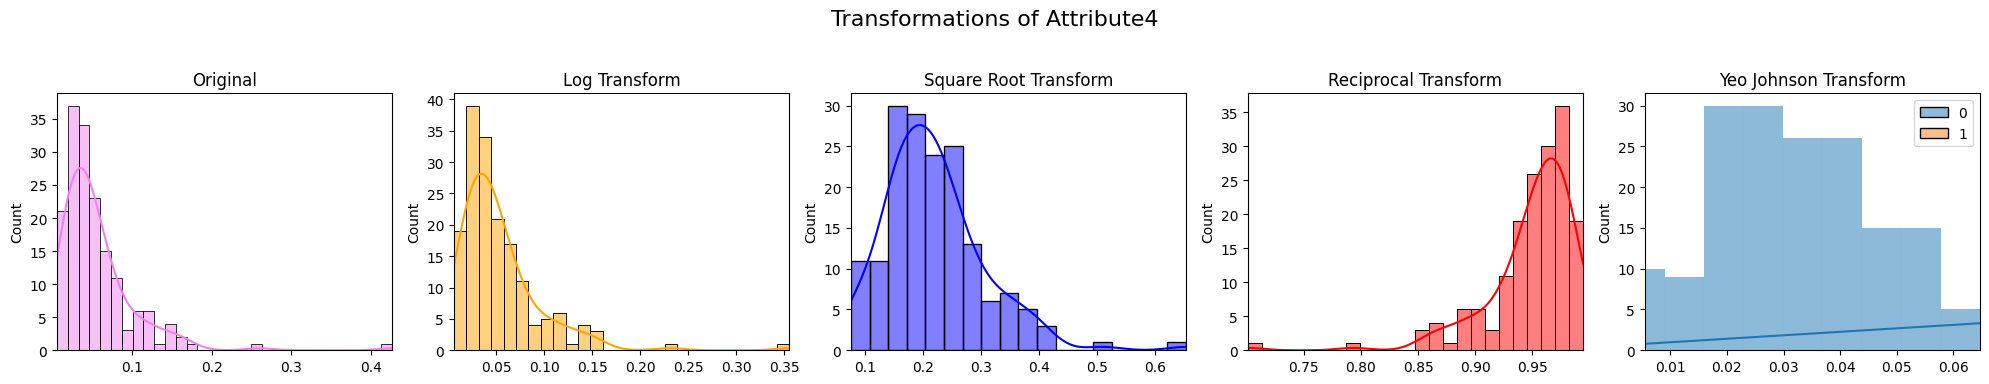

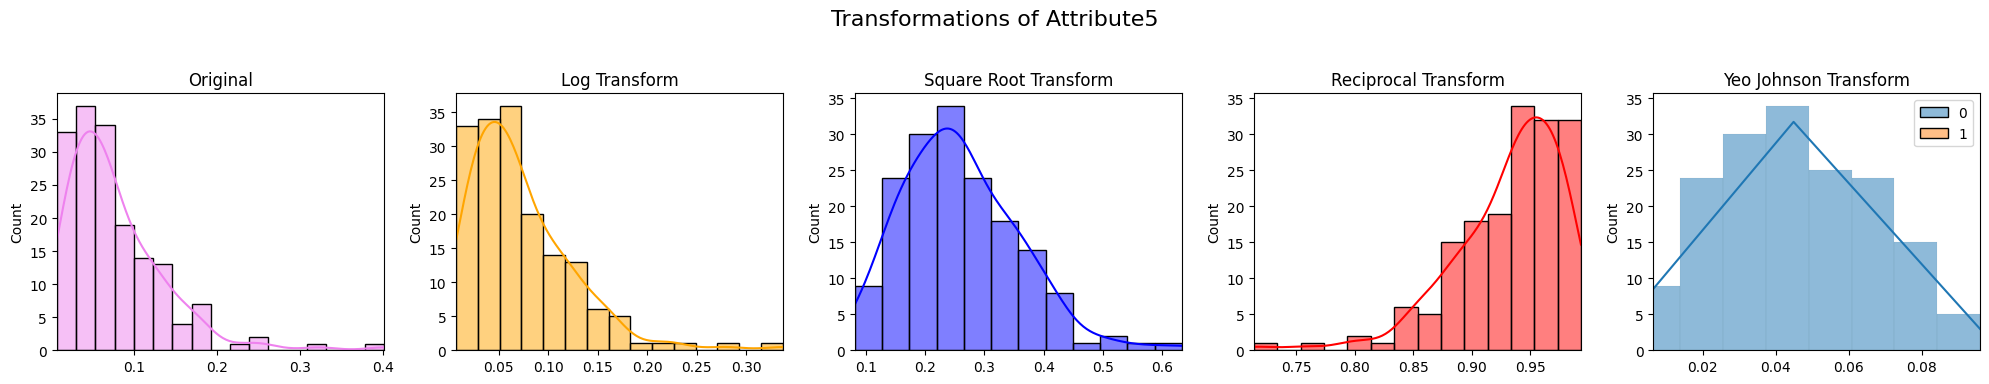

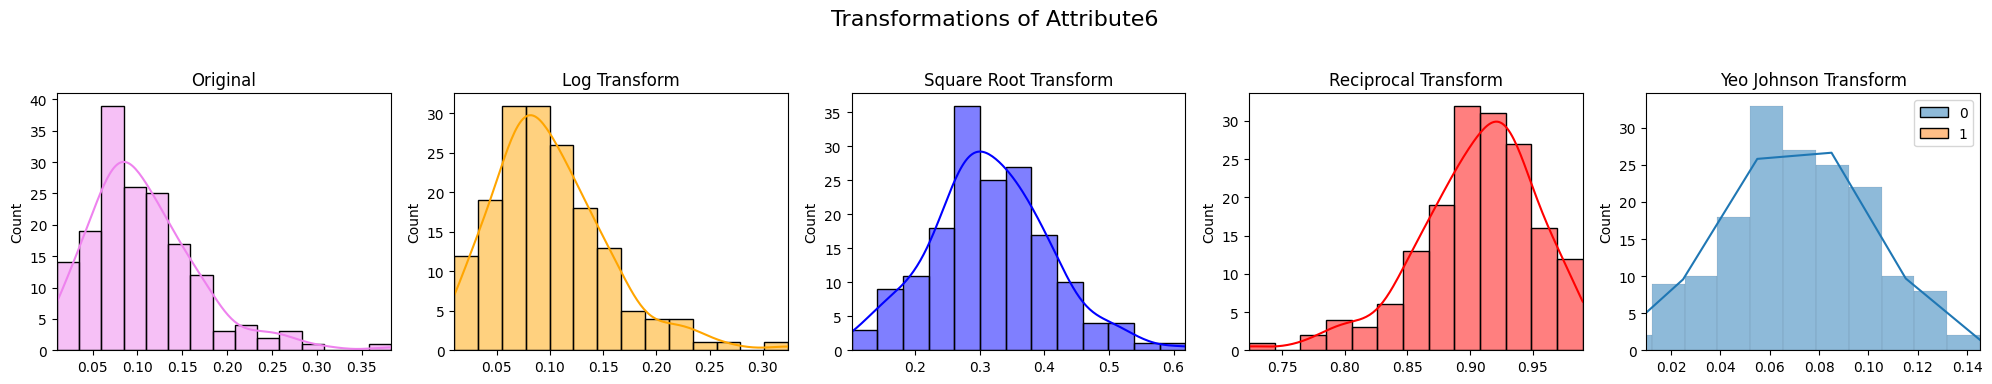

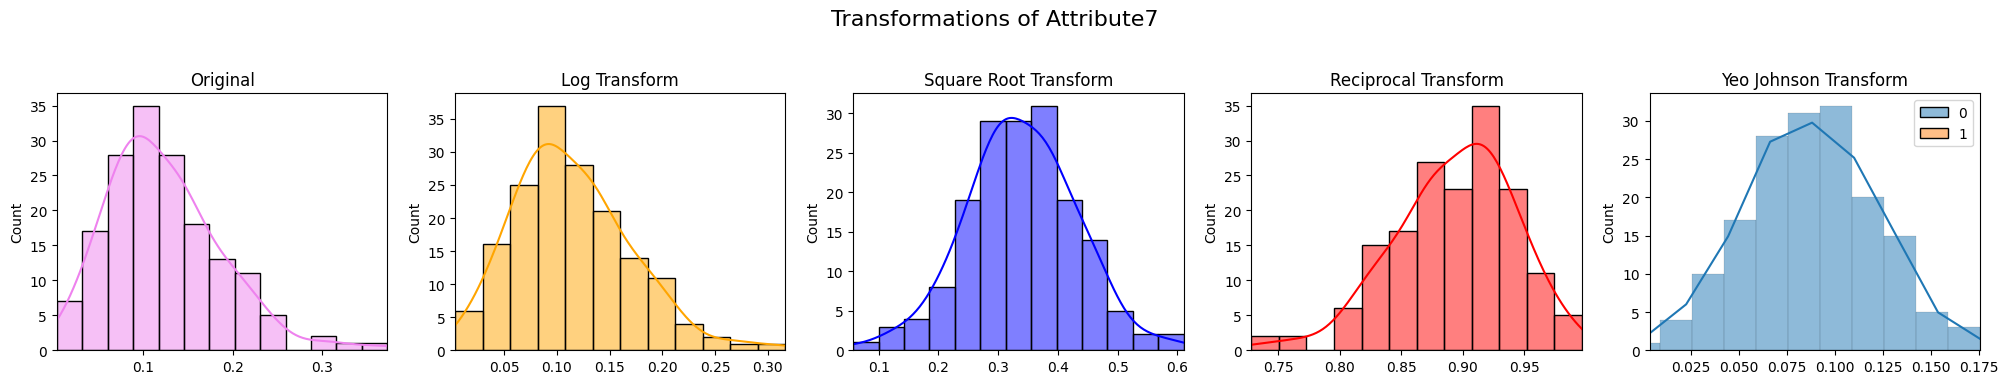

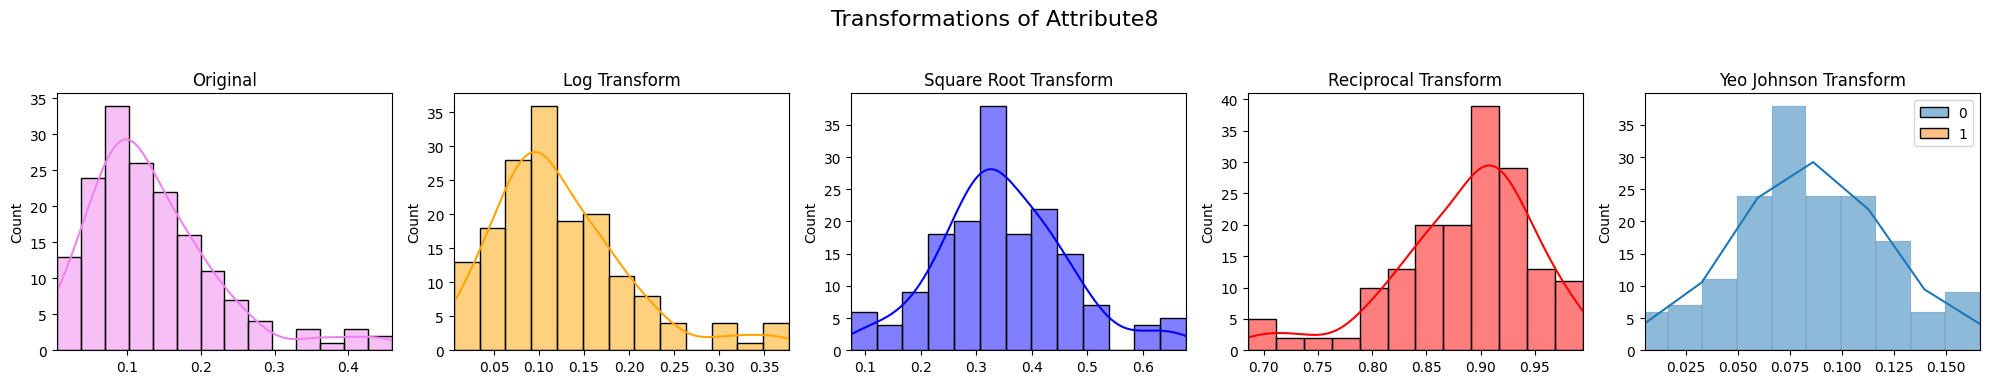

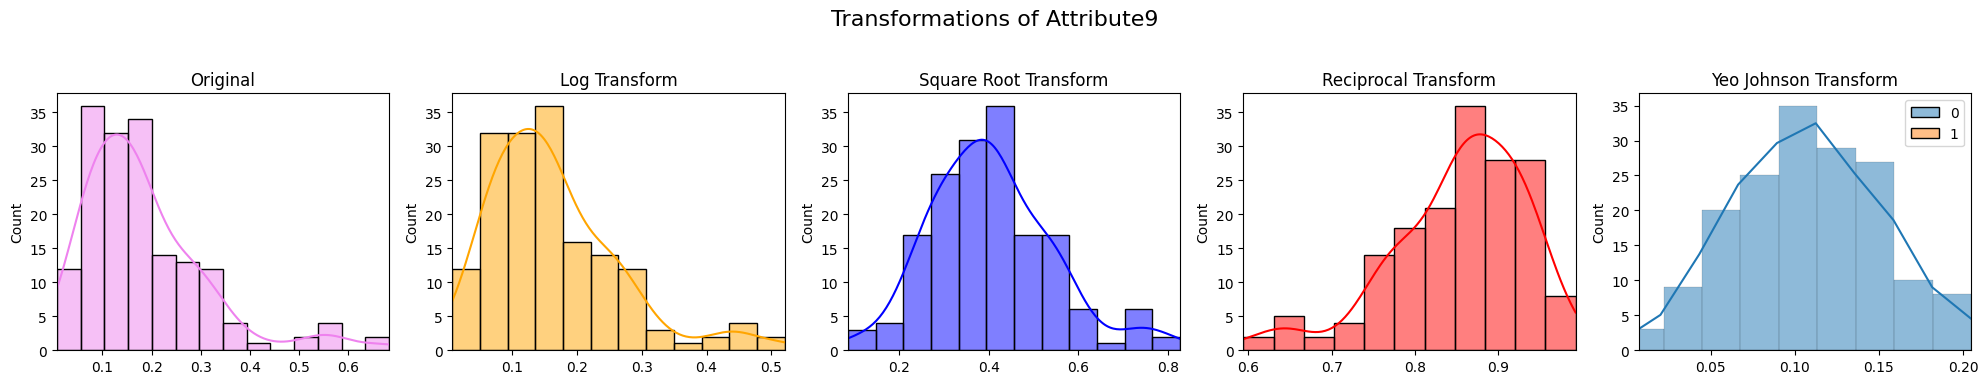

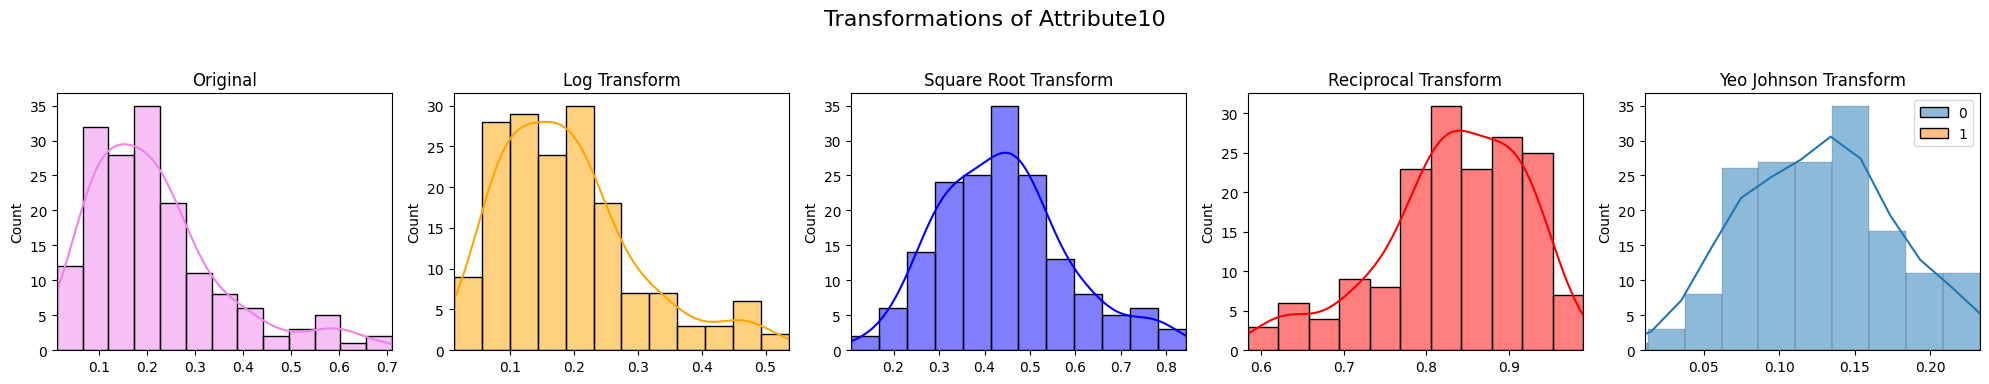

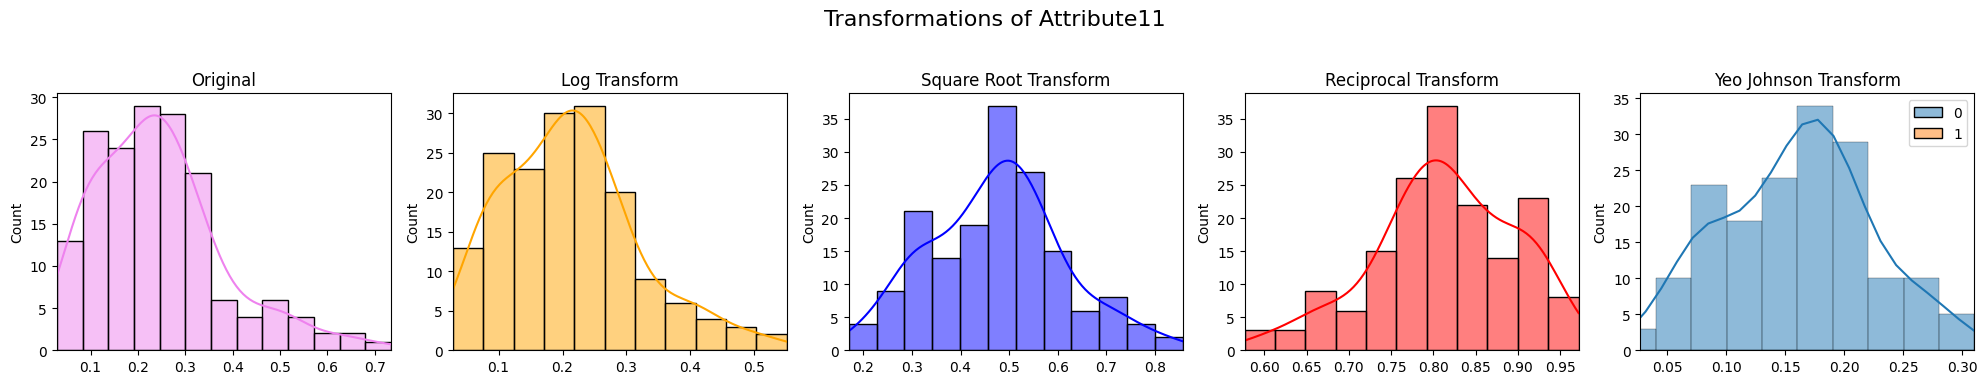

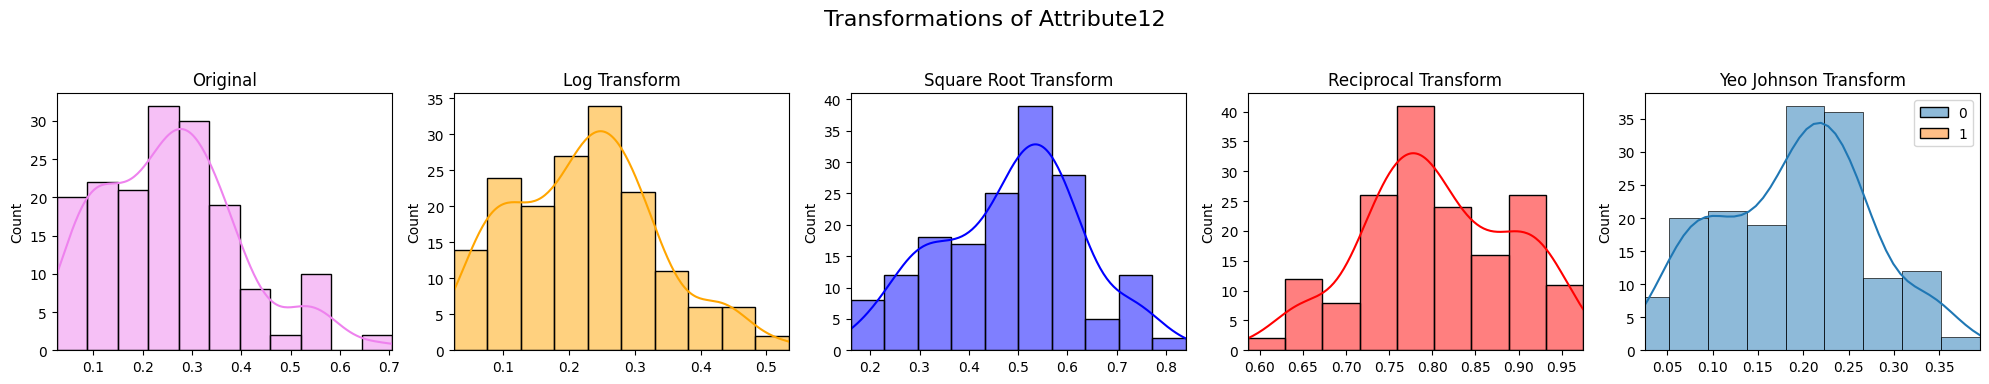

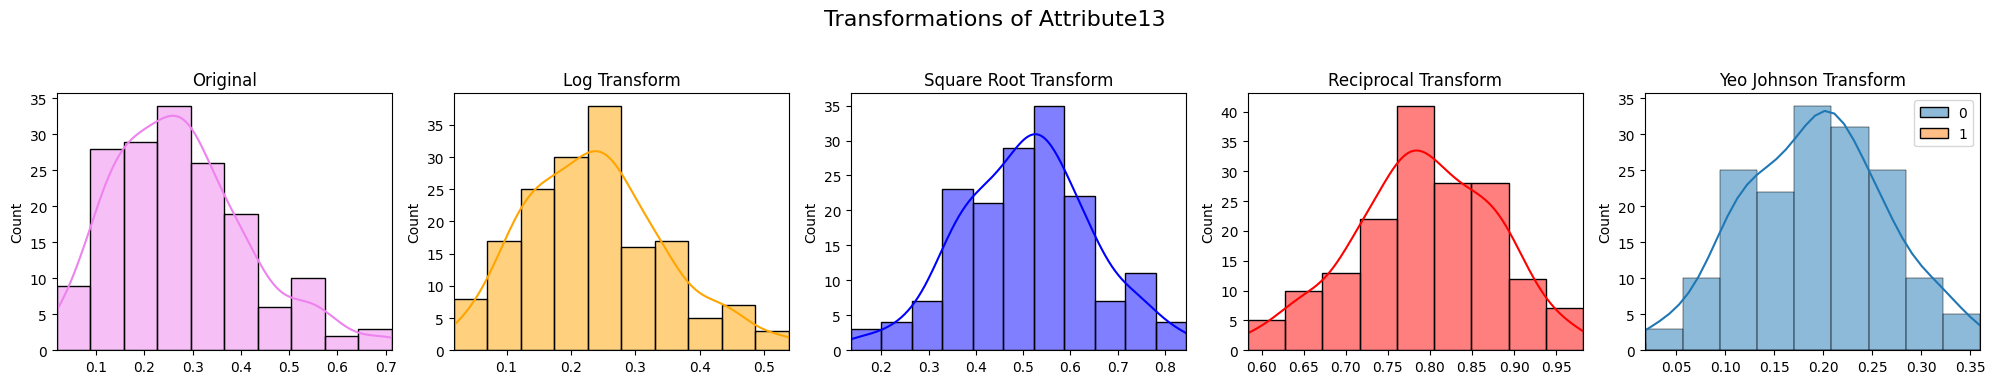

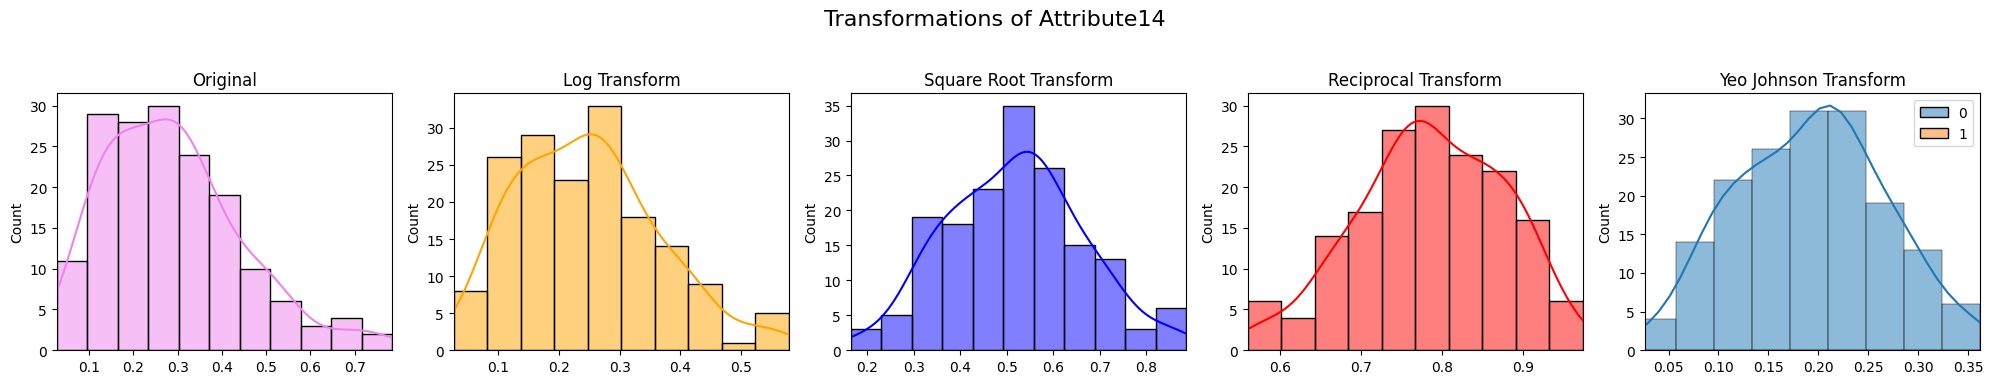

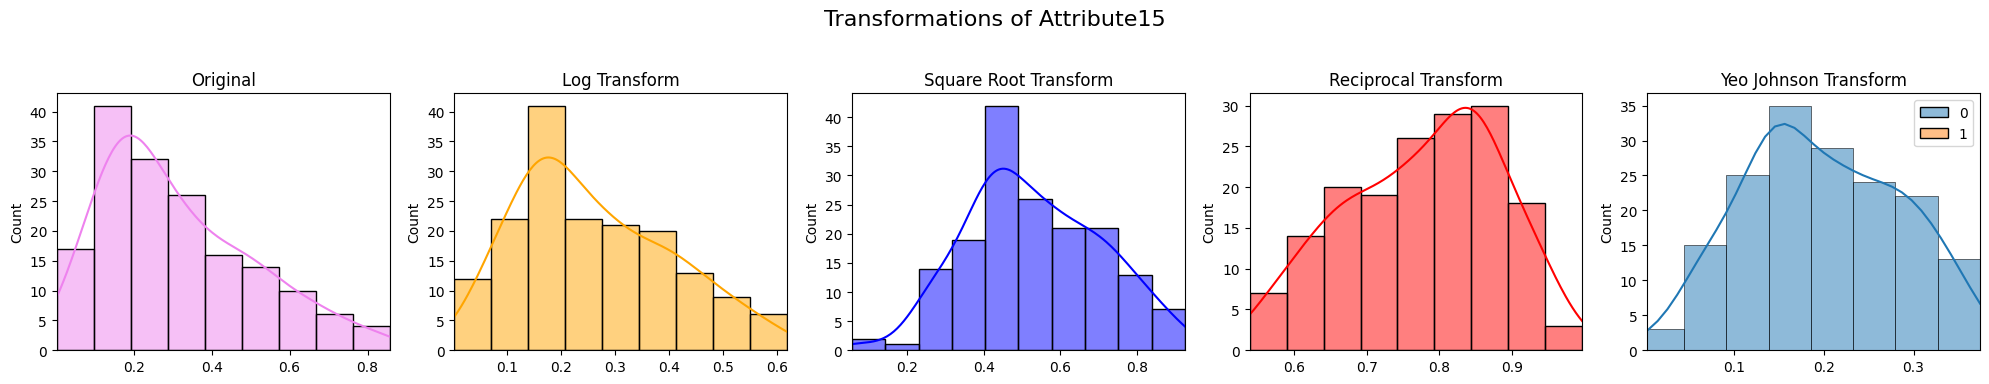

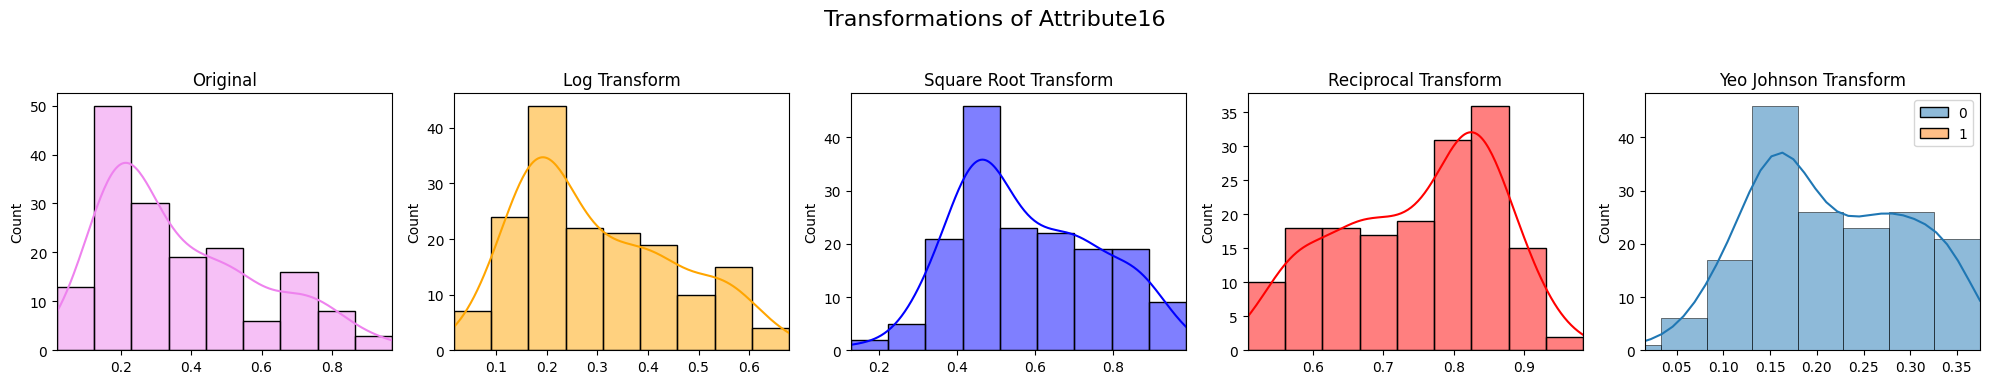

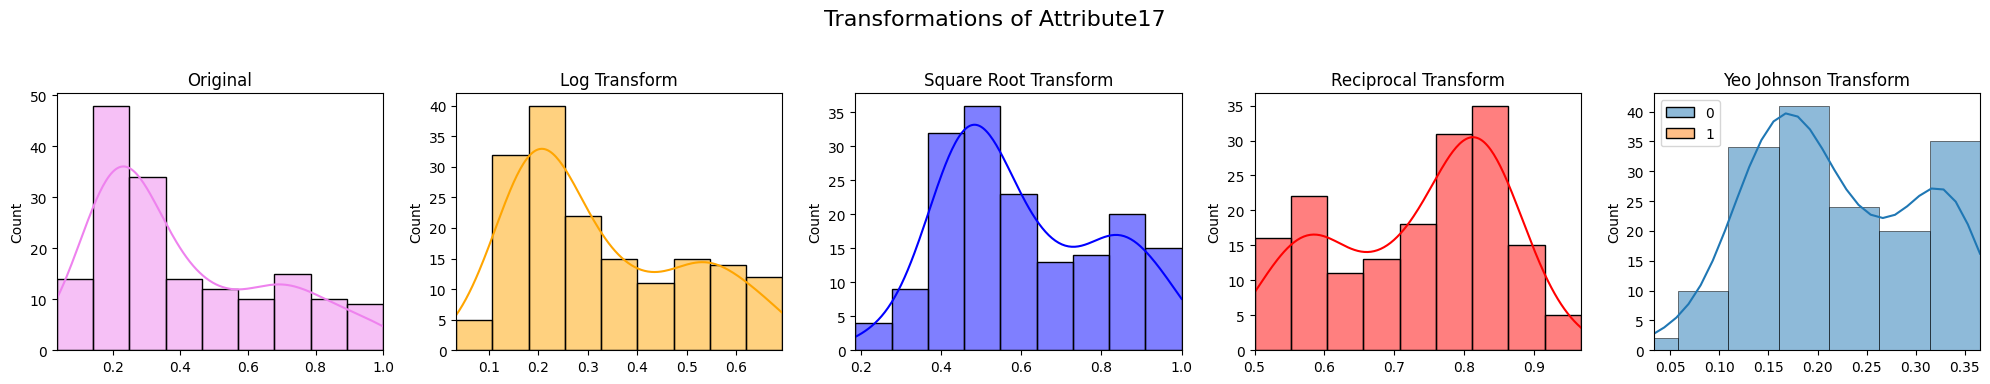

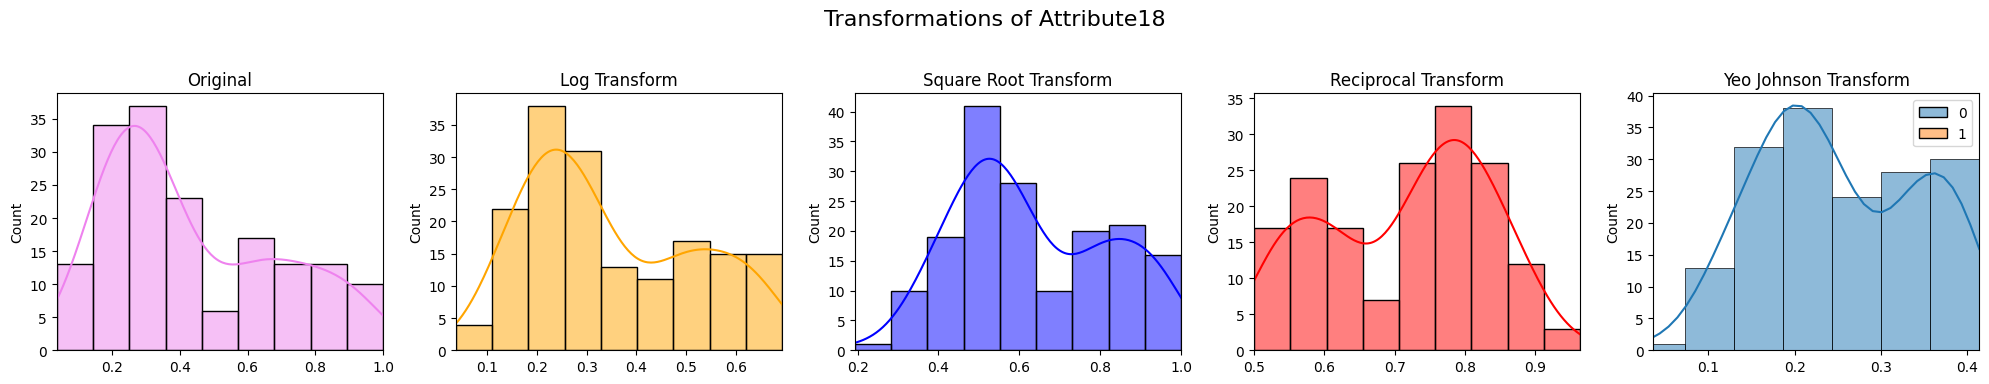

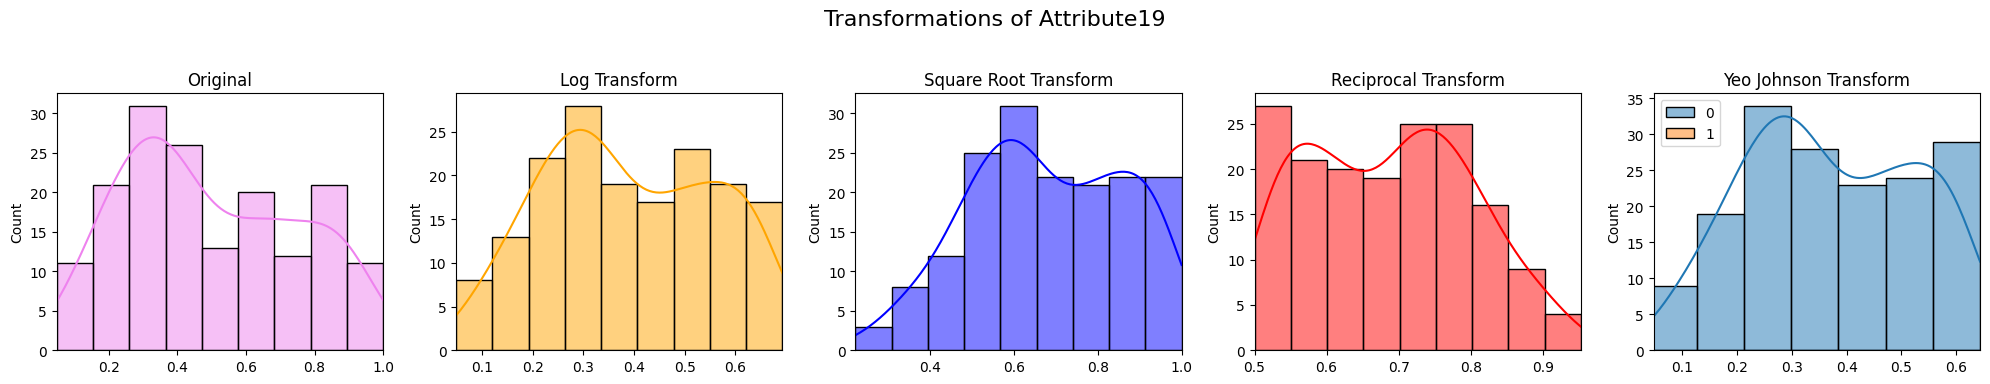

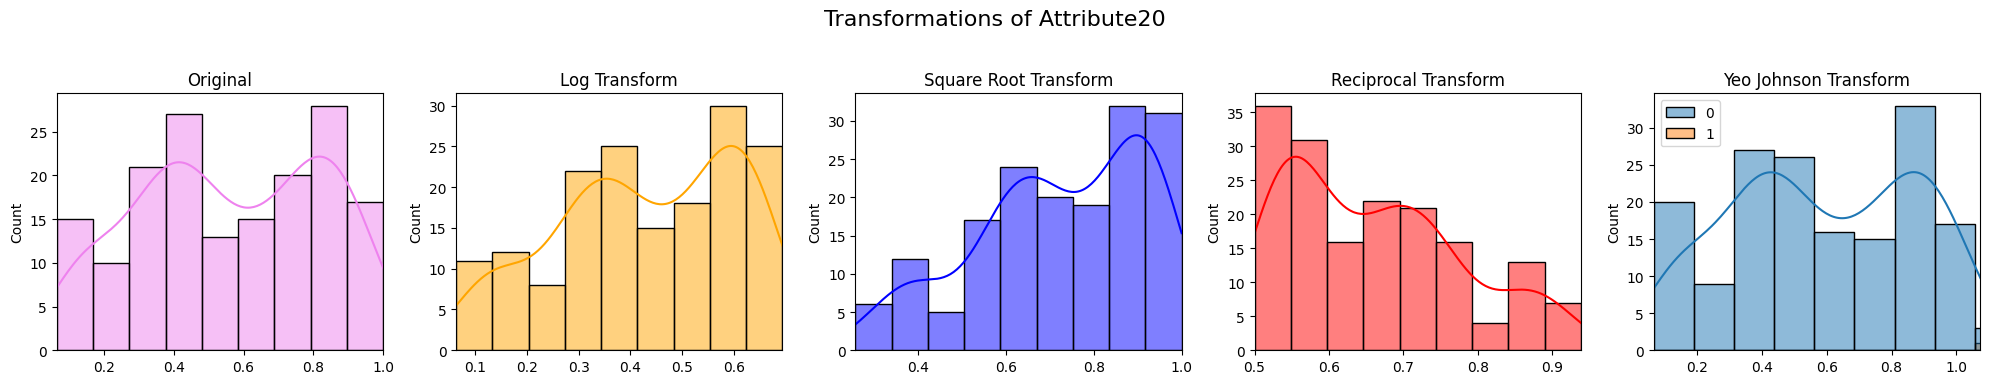

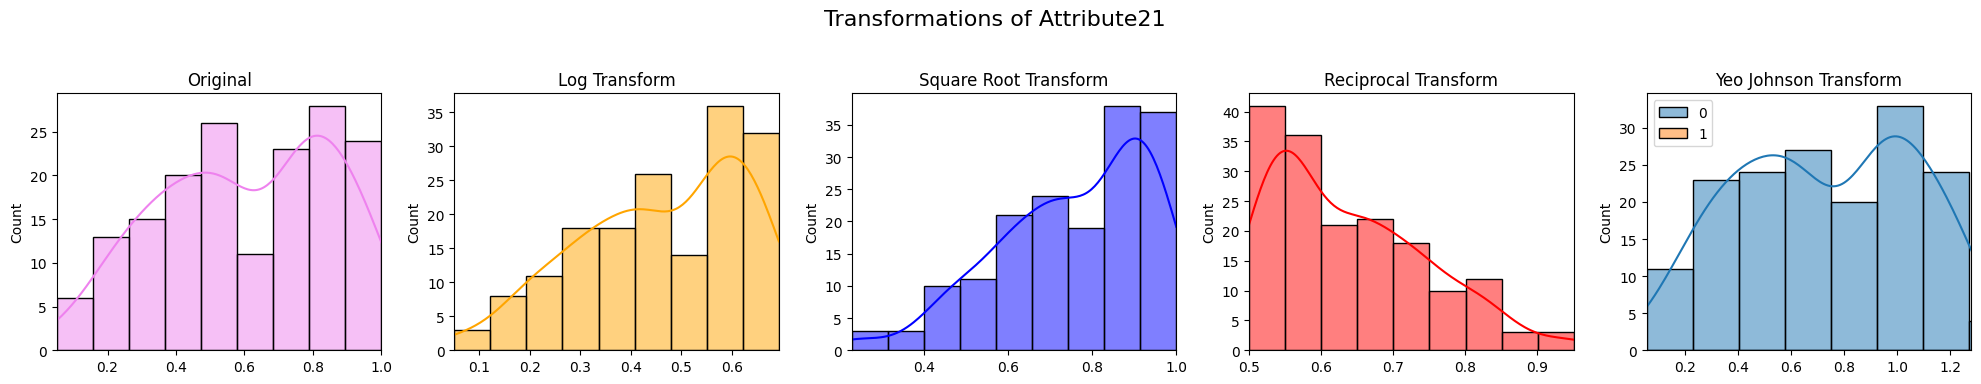

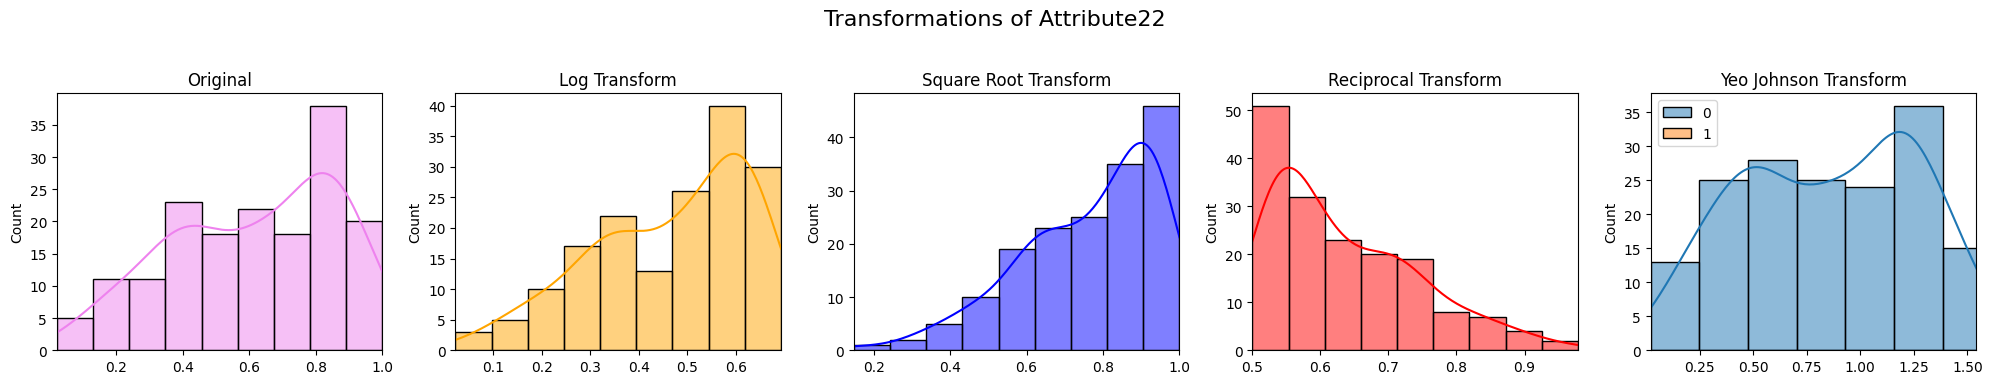

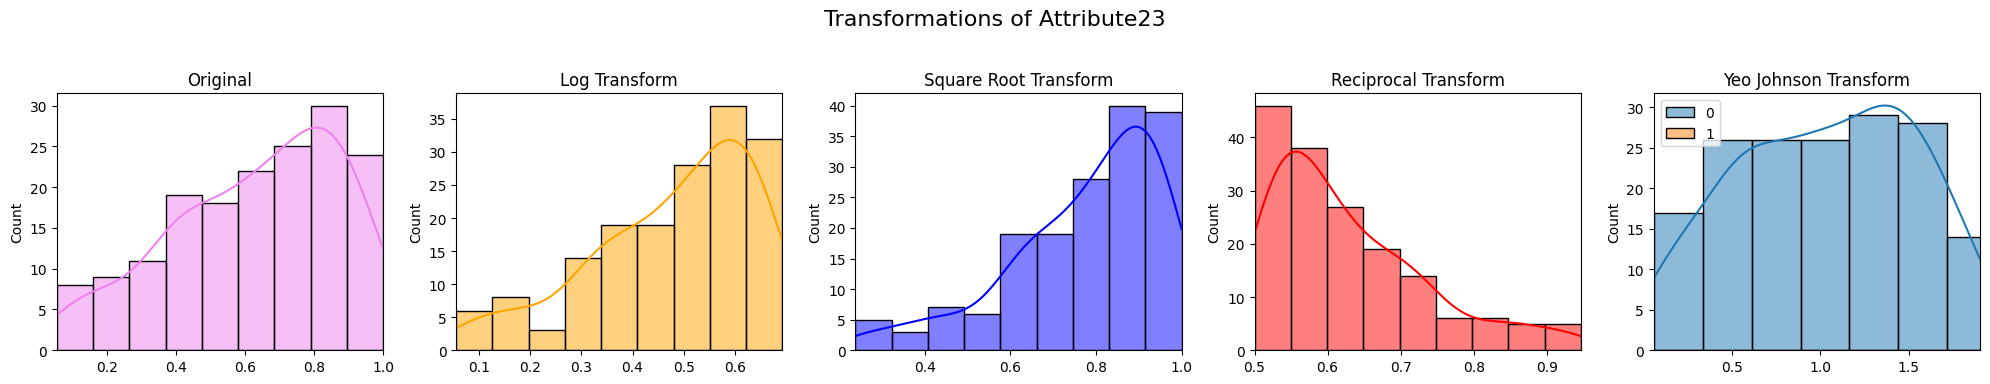

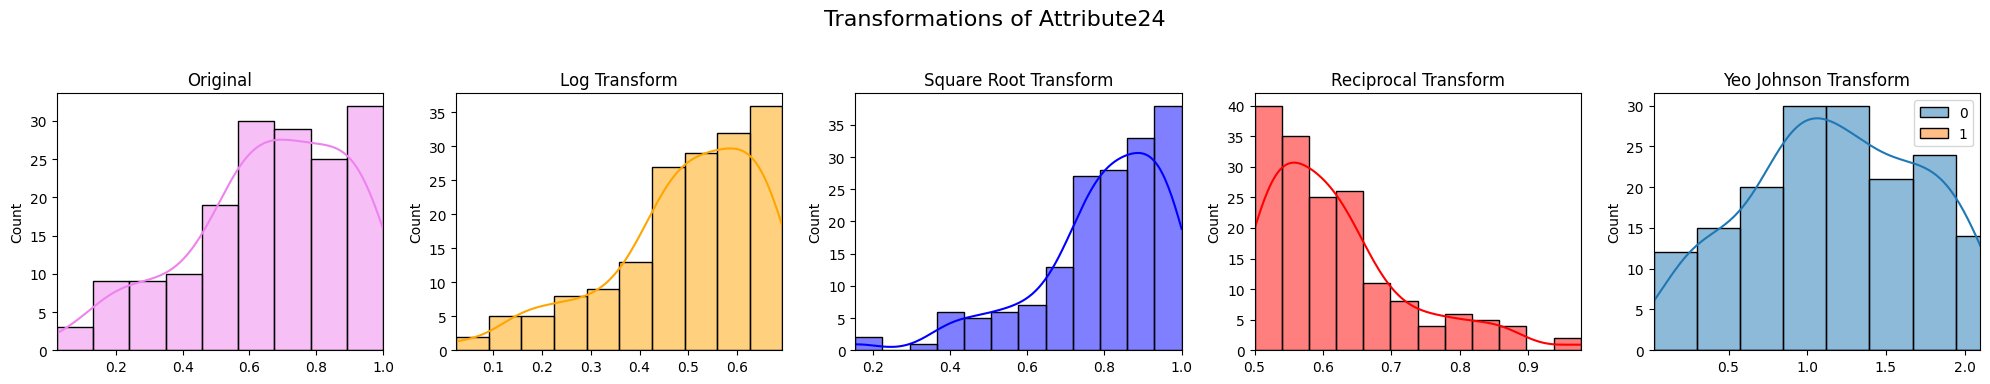

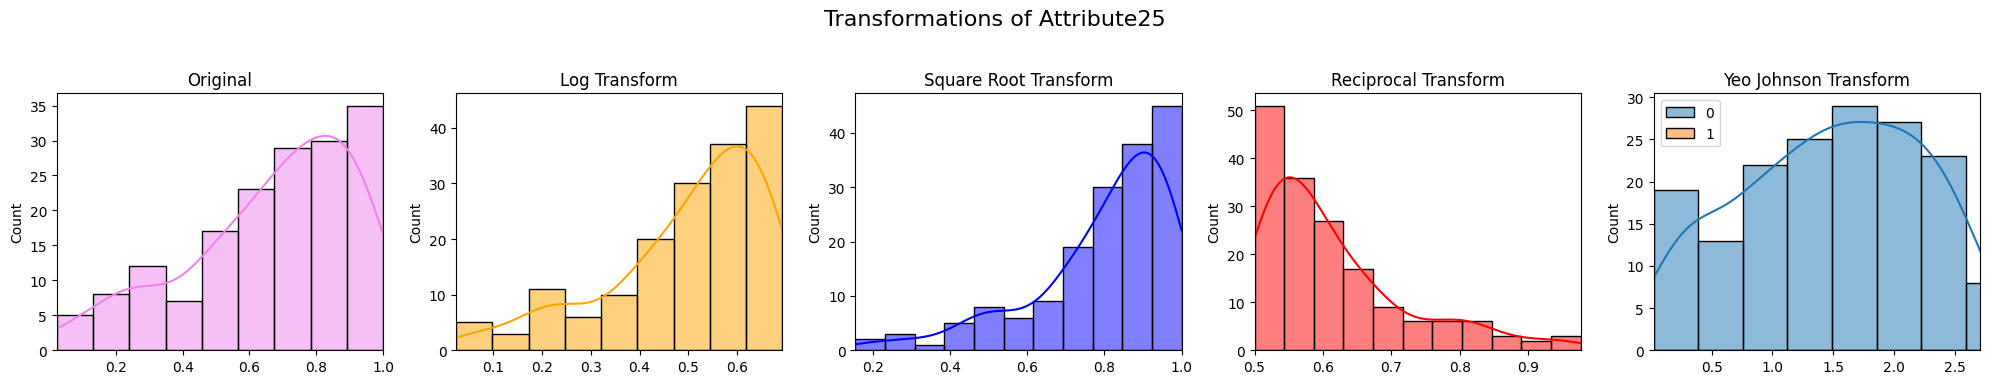

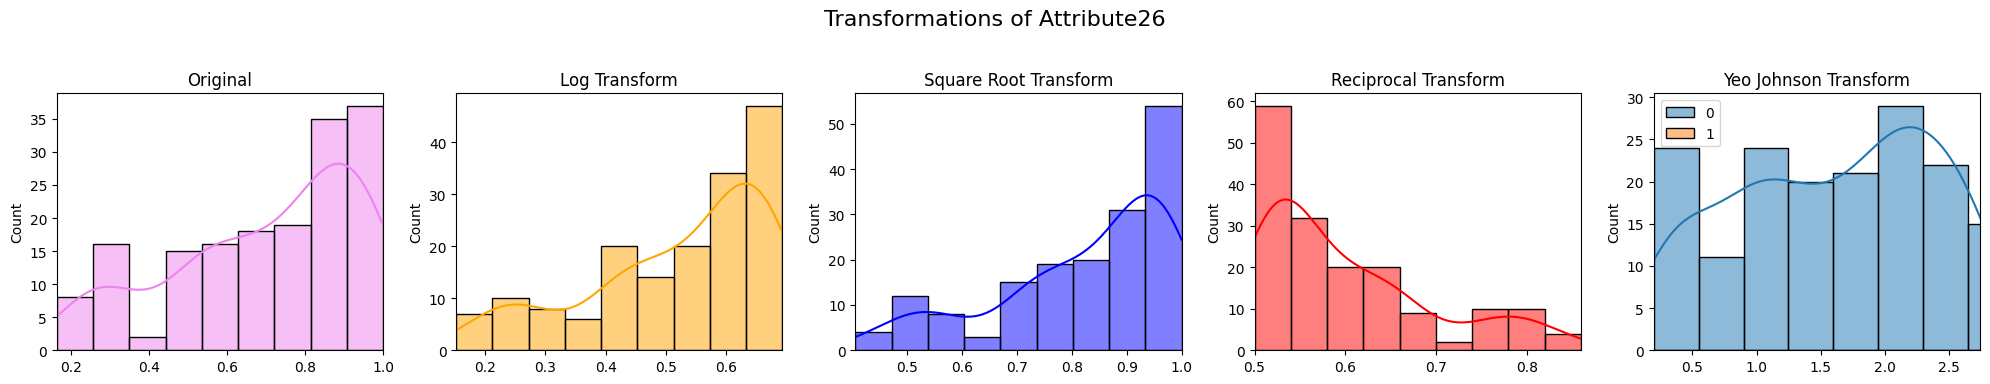

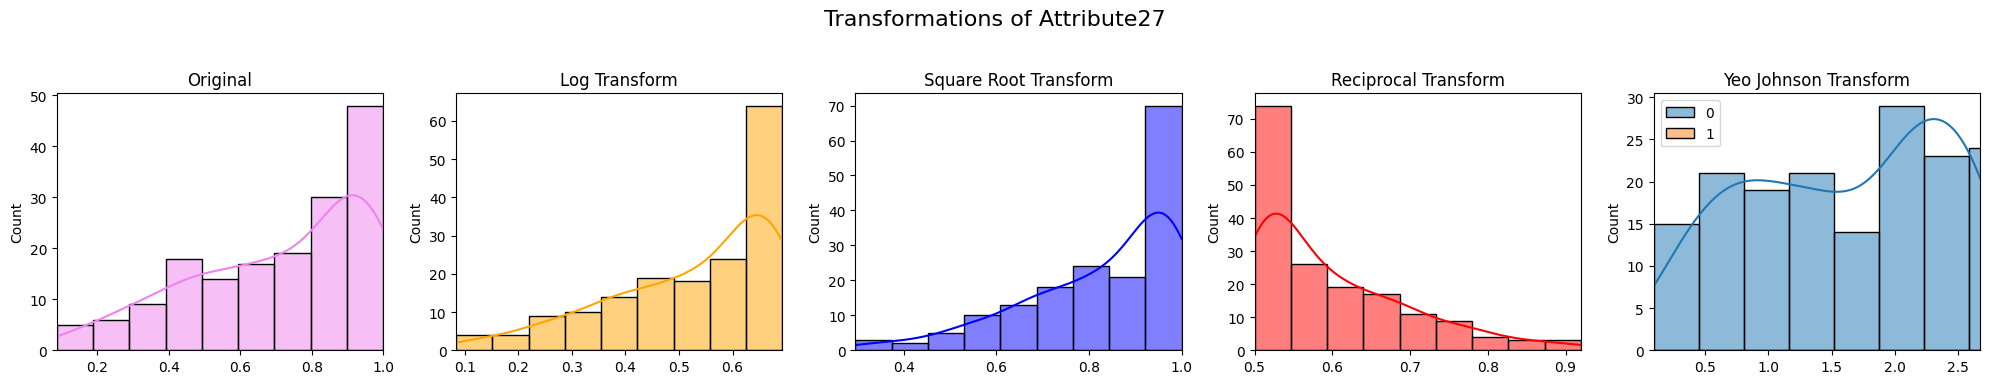

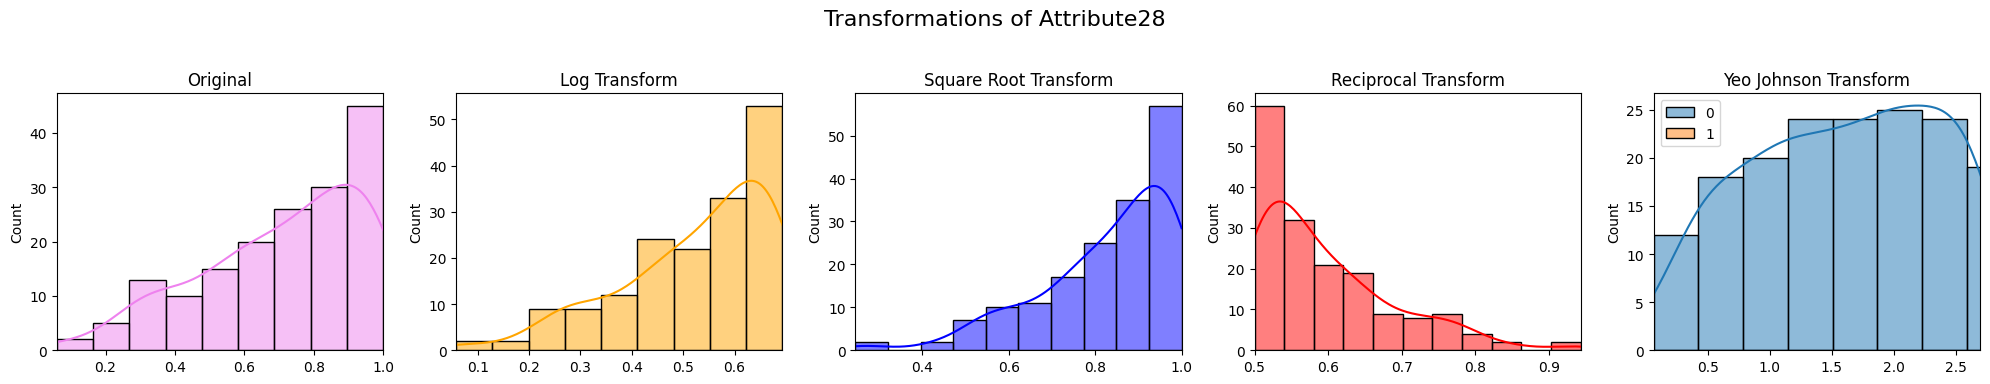

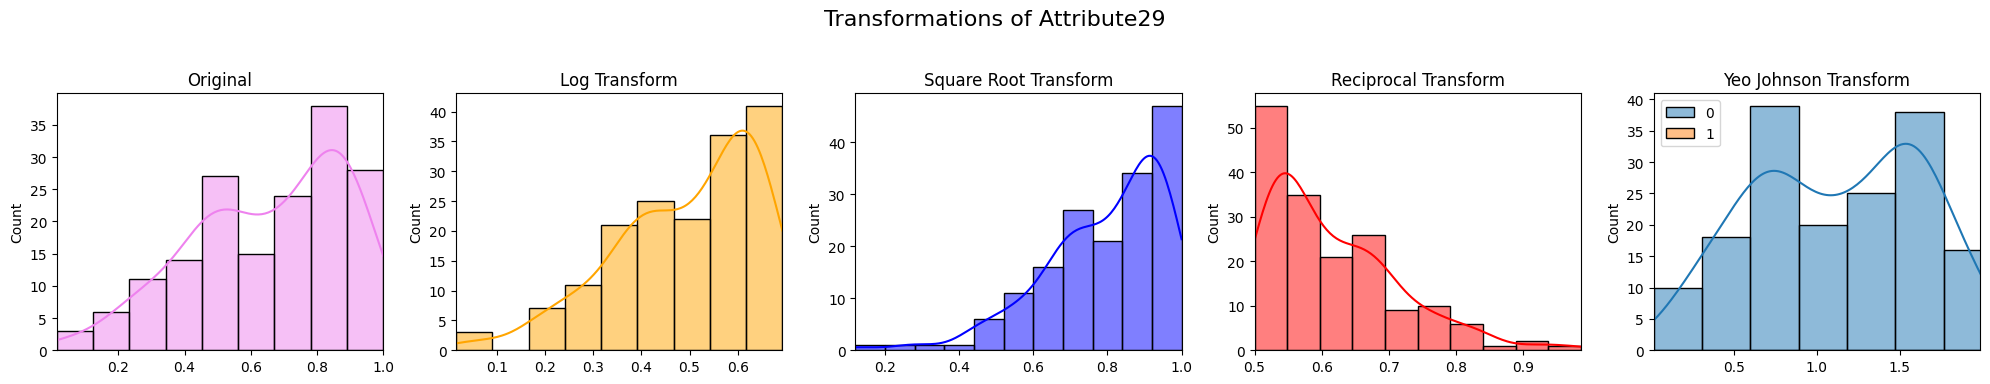

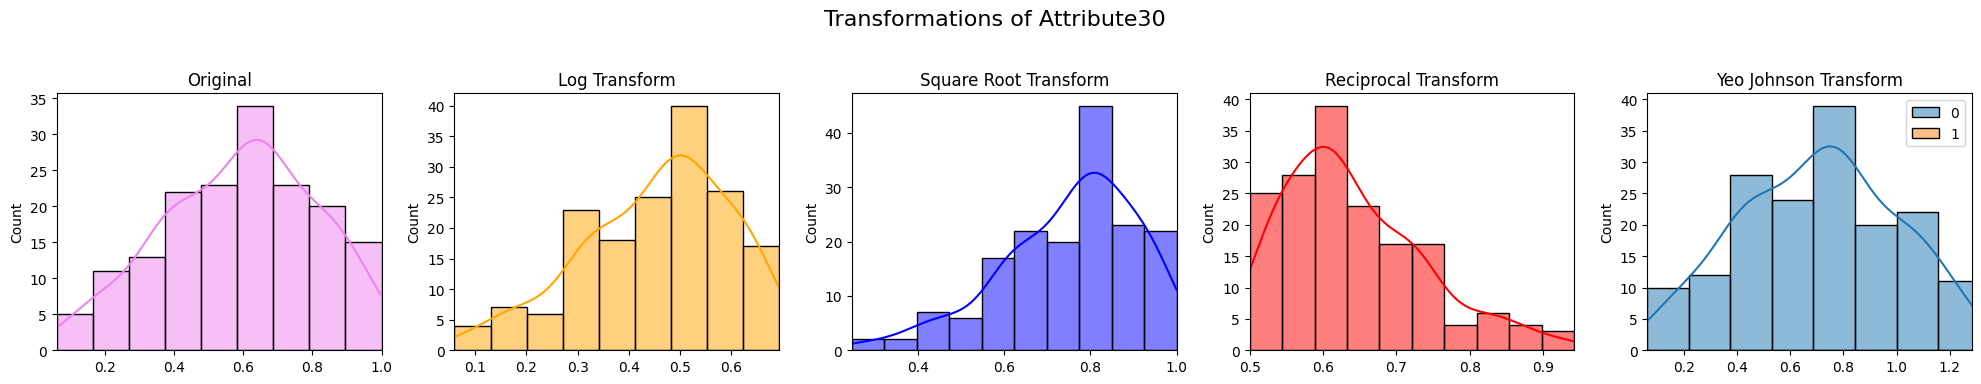

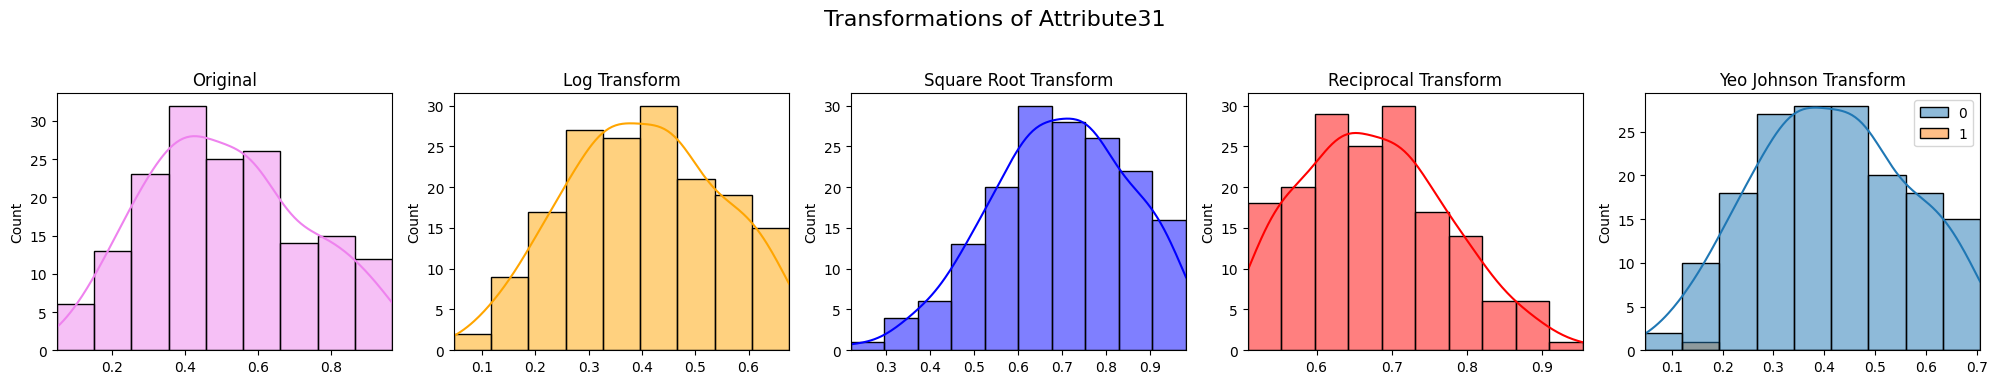

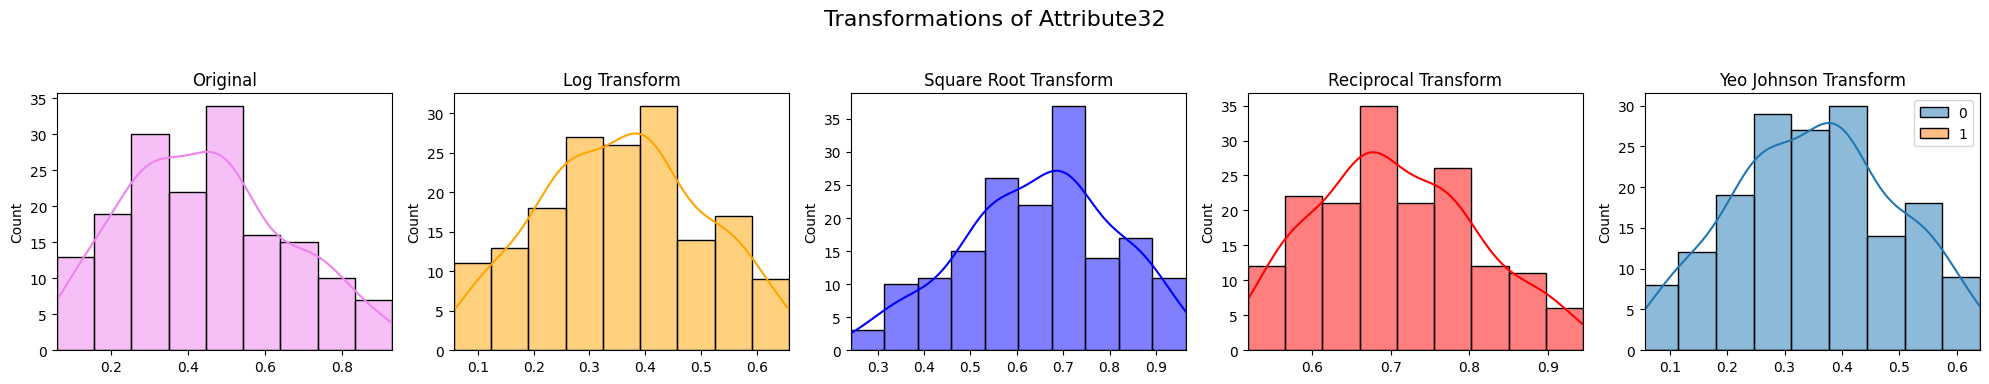

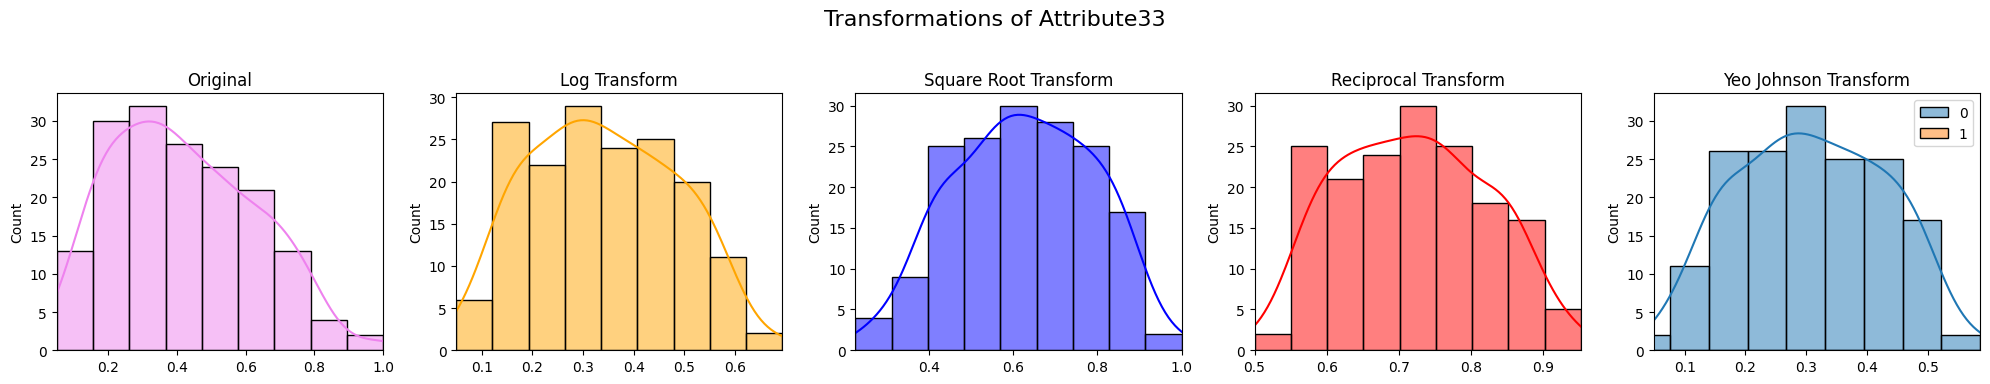

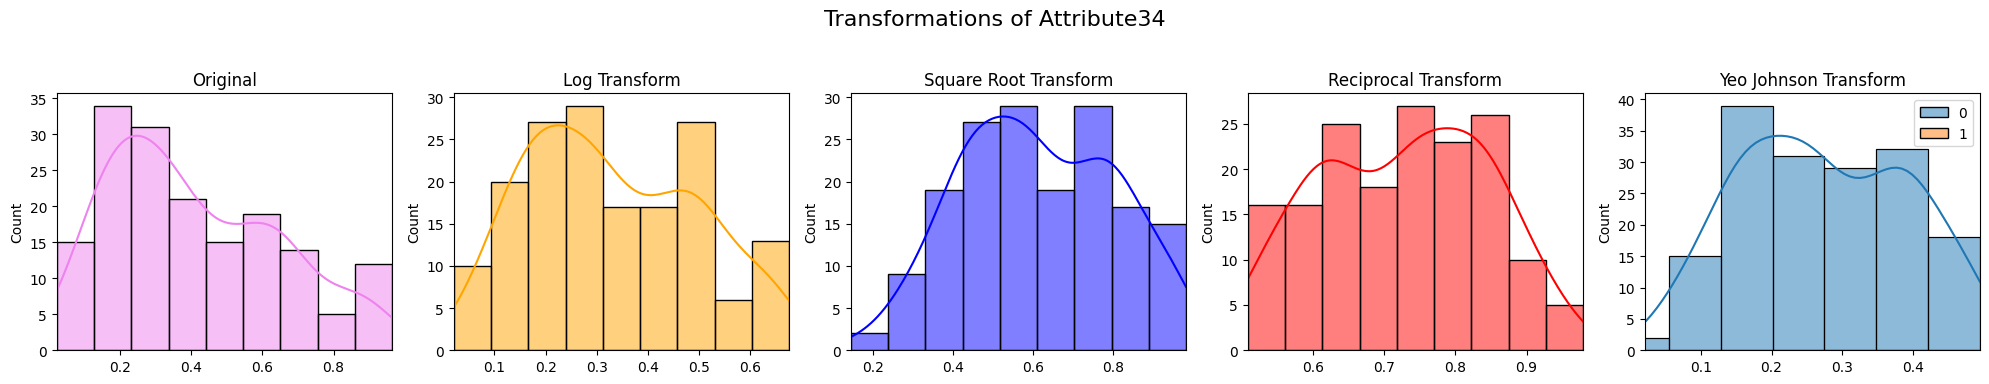

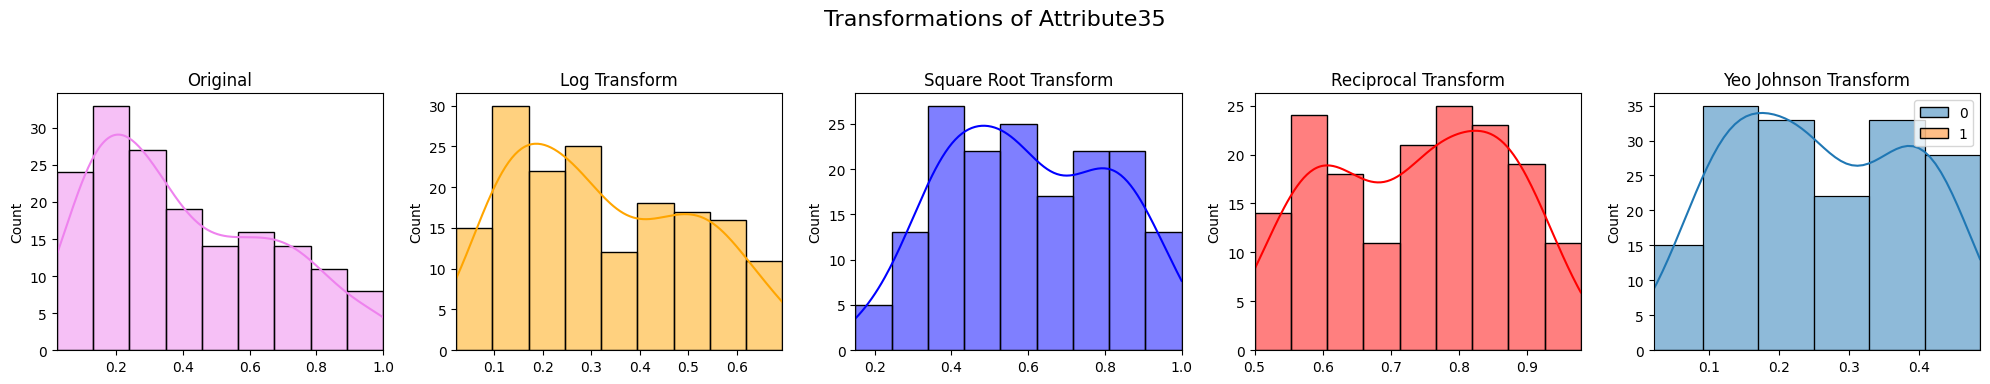

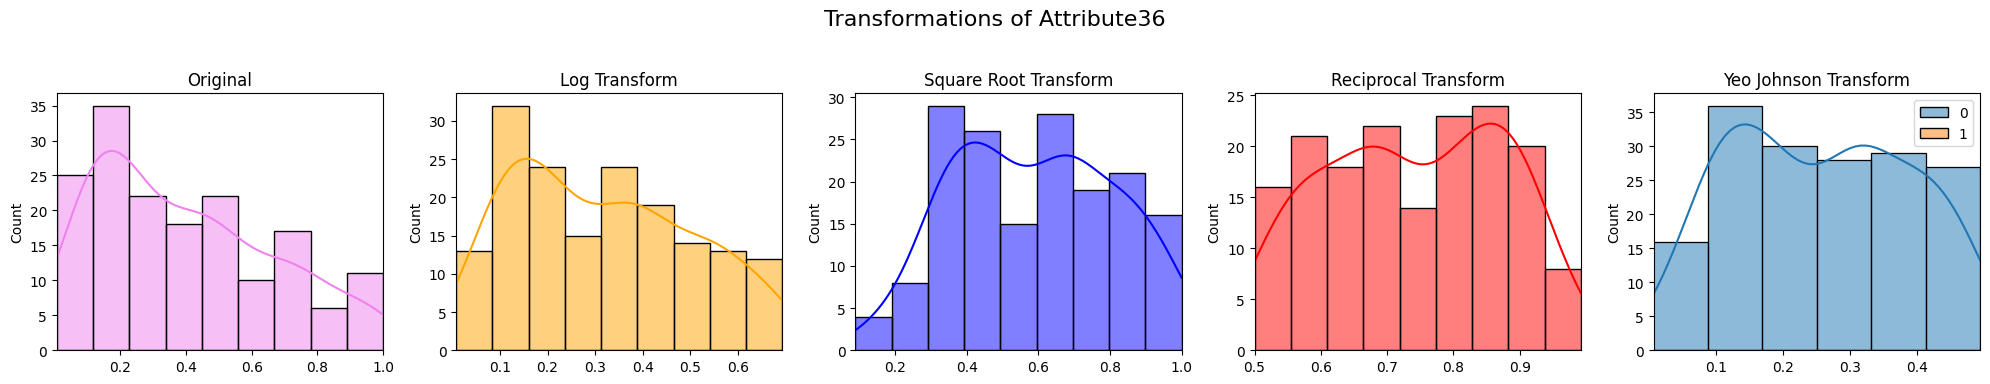

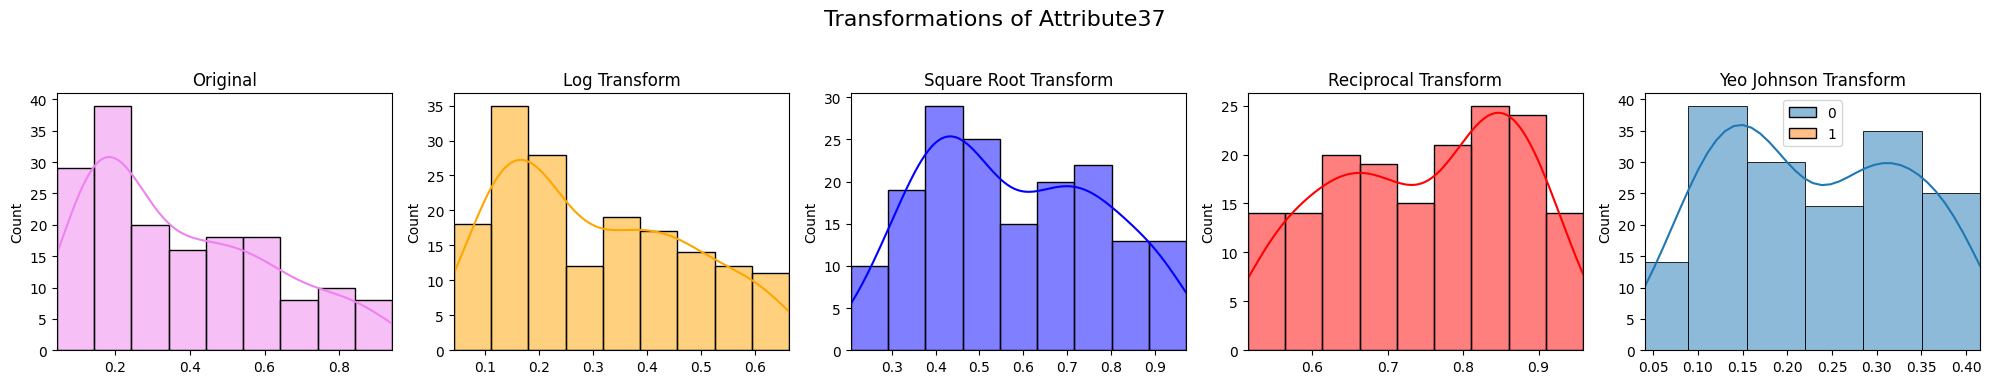

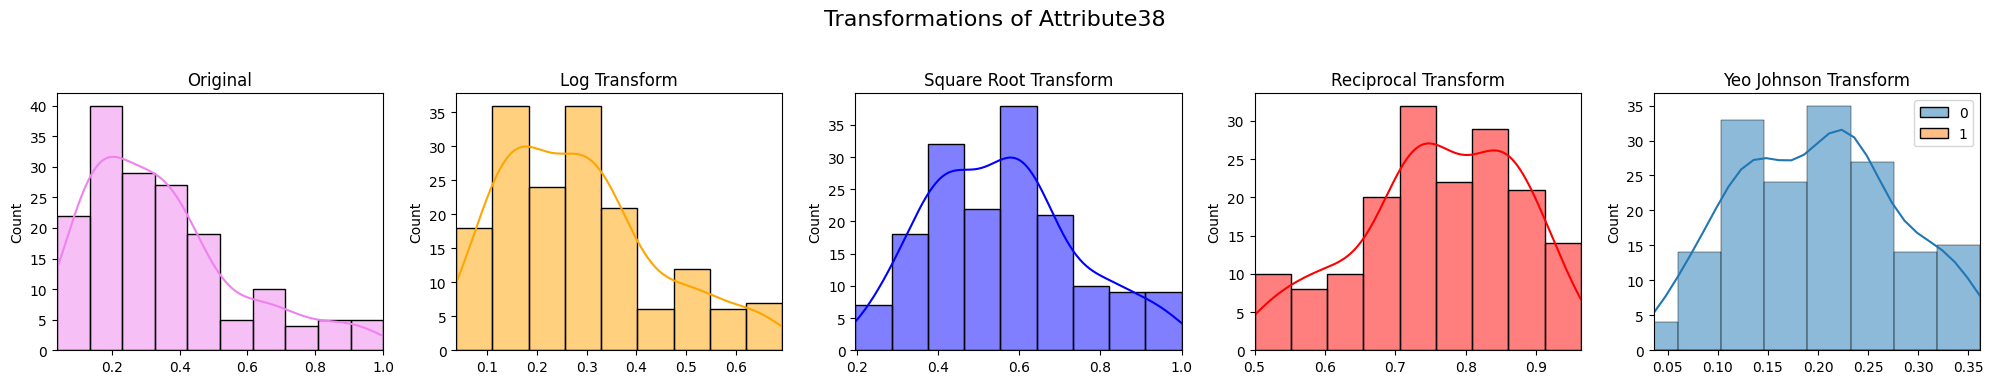

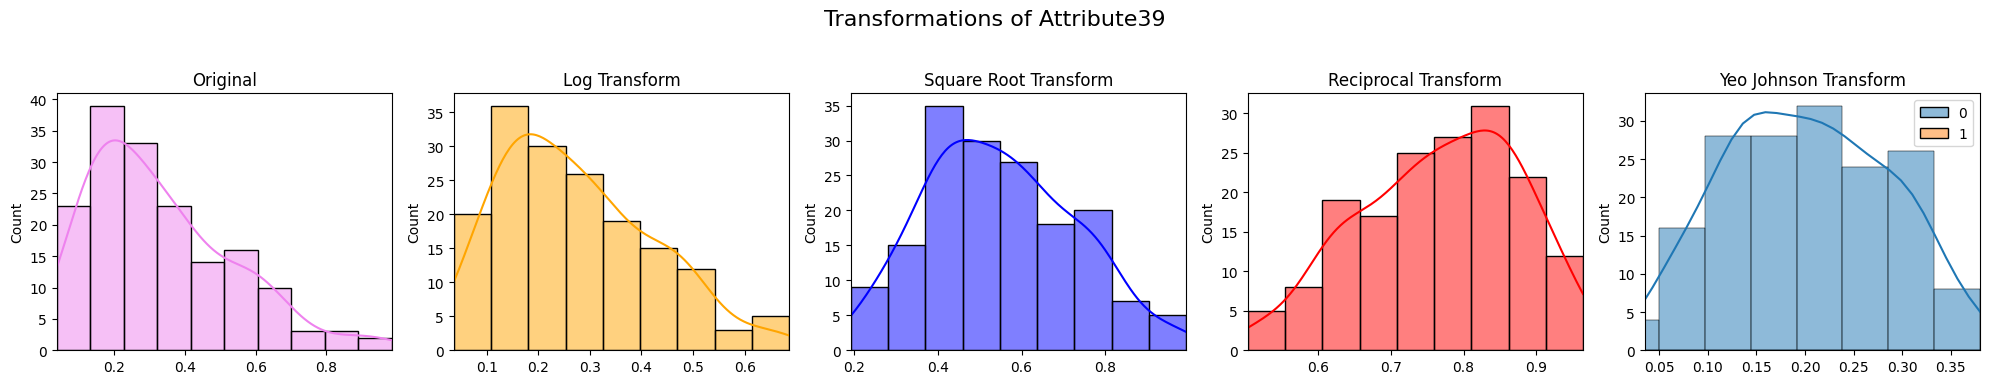

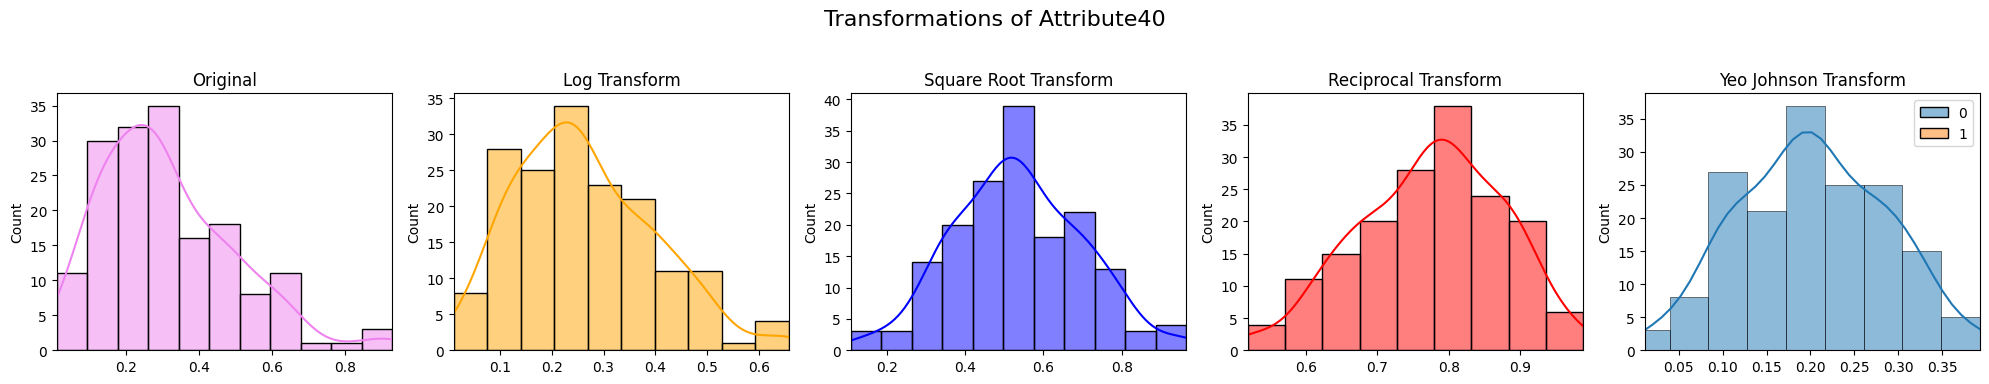

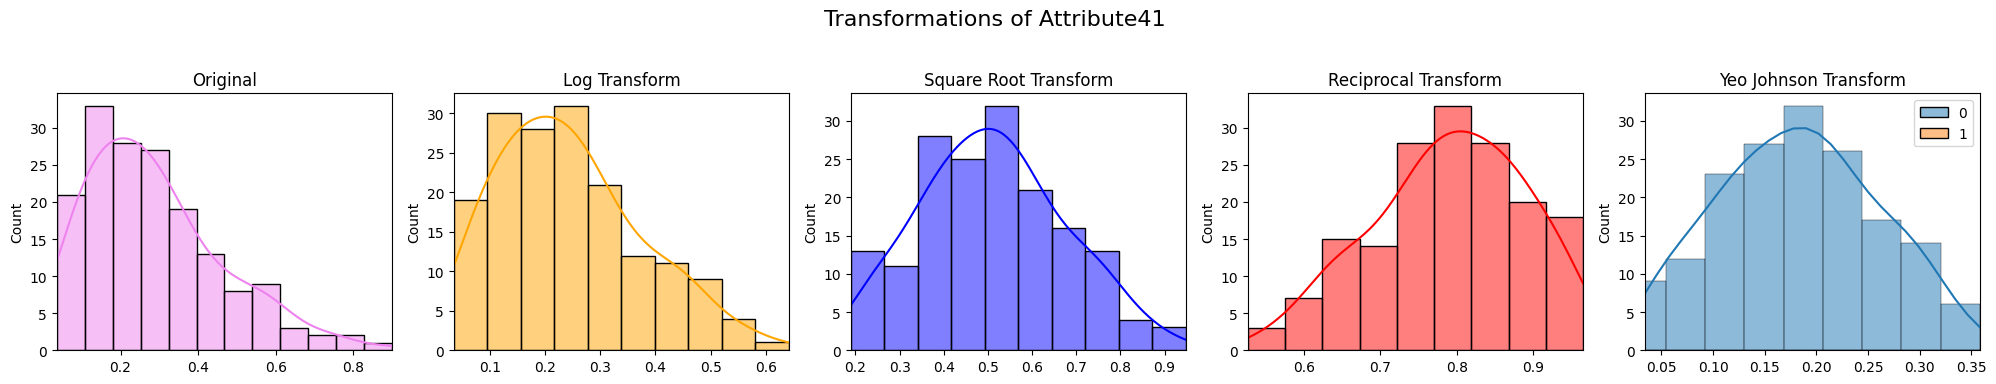

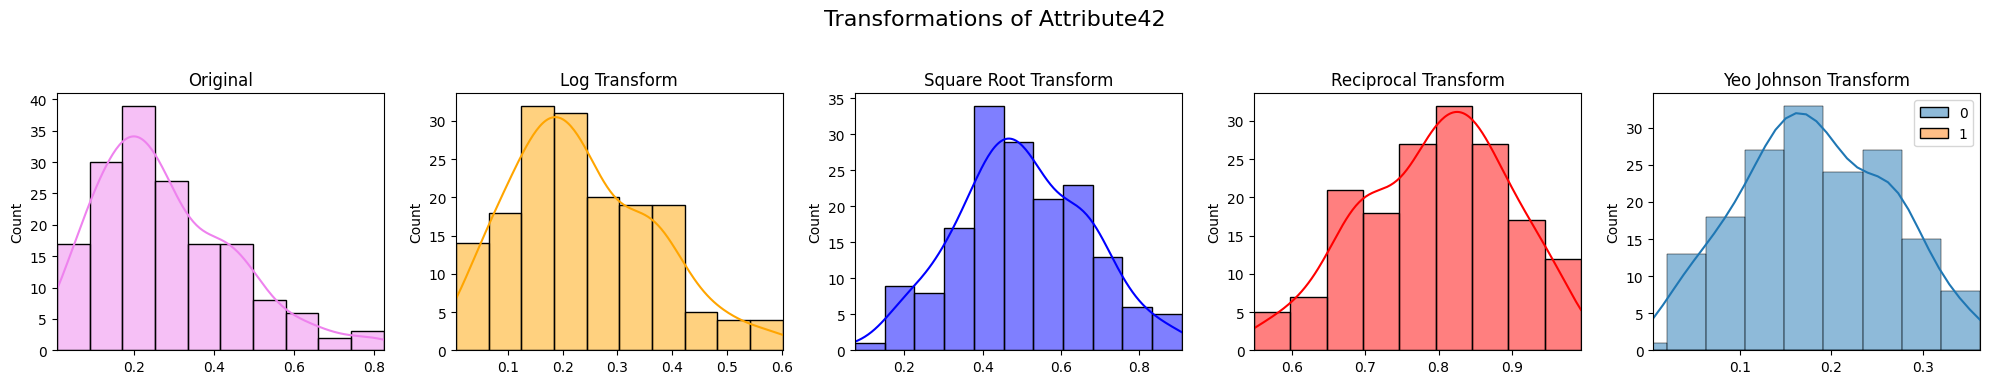

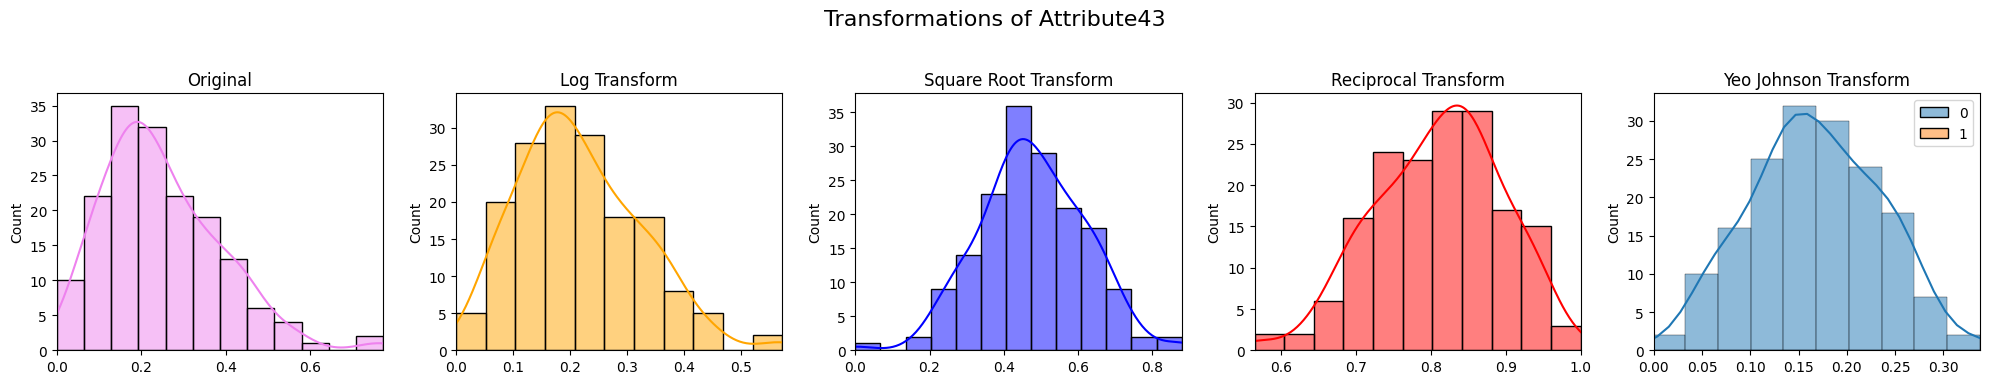

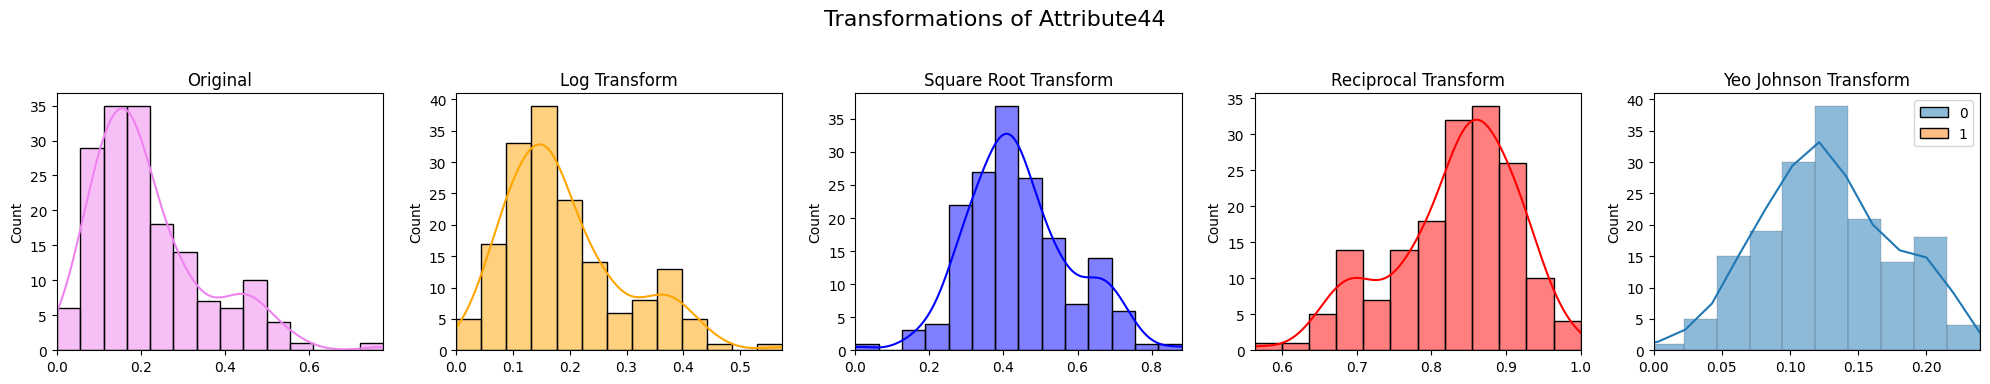

In [30]:
columns = [f'Attribute{i}' for i in range(1, 45)]
gamma = 0.5  # Define gamma as needed

def apply_transformations(data):

    # Apply multiple transformations to handle different distributions
    # Function Transformers
    log_data = np.log1p(data)
    sqrt_data = np.sqrt(data)
    reci_data = 1 / (data + 1)  # Add 1 to avoid division by zero

    # Power Transformers
    boxcox_data = boxcox(data + 1)  # Add 1 to avoid zero or negative values
    Yeo_Johnso_data = yeojohnson(data)

    return log_data, sqrt_data, reci_data, boxcox_data, Yeo_Johnso_data


for col_name in columns:
    # Get the original data
    original_data = train_df[col_name].values

    # Apply transformations to the column data
    log_data, sqrt_data, reci_data, boxcox_data, Yeo_Johnso_data = apply_transformations(original_data)

    # Calculate KDE for the log-transformed data
    kde_log = sns.kdeplot(log_data).get_lines()[0].get_data()
    plt.close()  # Close the plot to avoid displaying it

    # Create a 1x5 subplot for the original and transformed data
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    fig.suptitle(f'Transformations of {col_name}', fontsize=16)

    # Plot original data
    sns.histplot(original_data,  kde=True, color='violet', ax=axes[0])
    axes[0].set_title('Original')
    axes[0].set_xlim(min(original_data), max(original_data))

    # Plot log-transformed data
    sns.histplot(log_data, kde=True, color='orange', ax=axes[1])
    axes[1].set_title('Log Transform')
    axes[1].set_xlim(min(log_data), max(log_data))

    # Plot square root transformed data
    sns.histplot(sqrt_data, kde=True, color='blue', ax=axes[2])
    axes[2].set_title('Square Root Transform')
    axes[2].set_xlim(min(sqrt_data), max(sqrt_data))

    # Plot Reciprocal Transformed data
    sns.histplot(reci_data, kde=True, color='red', ax=axes[3])
    axes[3].set_title('Reciprocal Transform')
    axes[3].set_xlim(min(reci_data), max(reci_data))

    # # Plot Box-Cox transformed data
    # sns.histplot(boxcox_data, kde=True, color='red', ax=axes[4])
    # axes[4].set_title('Box-Cox Transform')
    # # axes[4].set_xlim(min(boxcox_data), max(boxcox_data))
    # axes[4].set_xlim(min(boxcox_data[0]), max(boxcox_data[0]))  # Access the array within the tuple


    # Plot Yeo Johnson Transformed data
    sns.histplot(Yeo_Johnso_data, kde=True, color='green', ax=axes[4])
    axes[4].set_title('Yeo Johnson Transform')
    axes[4].set_xlim(min(Yeo_Johnso_data[0]), max(Yeo_Johnso_data[0]))

    # Show the plot
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

after observing the all varients throught out all the attributes, "sqrt-transformation" is better suited for our case then followed by "Yeo_Johnso" then "Box-Cox"

## pipeline

The code below implements a custom feature engineering pipeline that:

- Calculates the square root of each feature.
- Standardizes the features.
- Encodes the target variable.

This transformed data can then be used for further modeling and analysis.

In [31]:
class CustomFeatureCreator(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.feature_names = [f'Sqrt_{feature}' for feature in X.columns]
        return self

    def transform(self, X):
        return np.sqrt(X)

    def get_feature_names_out(self, input_features=None):
        return self.feature_names

feature_engineering_pipeline = Pipeline([
    ('custom_transformer', CustomFeatureCreator()),
    ('scaler', StandardScaler())
])


# Fit and transform the data using the pipeline & Encode the target variable
Train_X_transformed = feature_engineering_pipeline.fit_transform(train_X)
Train_y_transformed = LabelEncoder().fit_transform(train_y)

# Now Train_X_transformed contains the scaled and square root transformed features,
# and Train_y_encoded contains the label encoded target variable.
print("Transformed Features Shape:", Train_X_transformed.shape)
print("Encoded Labels Shape:", Train_X_transformed.shape)

Transformed Features Shape: (166, 60)
Encoded Labels Shape: (166,)


In [33]:
Train_X_transformed, Train_y_transformed

(array([[-3.20225231e-01, -1.72965038e+00, -9.83554256e-01, ...,
         -1.10359534e+00, -2.43256658e-01, -4.02756945e-01],
        [-7.62455037e-01,  1.71934332e-01, -1.87461039e-01, ...,
         -1.70062670e+00, -1.33441960e+00,  5.26676025e-01],
        [-2.74999753e-01, -2.19385605e-01, -1.11105026e+00, ...,
         -4.88424717e-01, -1.12383700e+00, -1.59464750e+00],
        ...,
        [ 4.68932900e-01,  4.57811558e-01, -2.96539675e-01, ...,
          7.13015195e-01,  5.17786005e-02, -7.22123056e-01],
        [-2.01460188e-02,  3.63753779e-01,  6.77951588e-03, ...,
          1.79128551e+00,  2.25517885e+00,  2.03489663e+00],
        [ 6.54514508e-01,  9.39383493e-01,  3.50734781e-02, ...,
          5.31428516e-01, -8.68650934e-04, -1.21389753e-01]]),
 array([1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
        0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0,
        1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       

# Model building

On the site it is mentioned the accuracies by the models..

- XgBoost = 84.6
- SVM = 80.7
- Random Forest = 90.3
- NN = 82.6
- Logistic = 77

now that expect logistic we have better results for the rest of model they've used. so i'm gonna try to experiment with tuning hyperparameters of "logistic" and also with other different models like
- Naive Bayes
- Decision Tree
- Gradient Boosting
- XgBoost (tuning hyperparameters)
- Extra Trees

In [49]:
NR_FOLDS = 10

# Setting up models
models = {
    'Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(class_weight='balanced', solver='liblinear', max_iter=50),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(scale_pos_weight=sum(Train_y_transformed == 0) / sum(Train_y_transformed == 1)),
    'Extra Trees': ExtraTreesClassifier(class_weight='balanced'),
    'BaggingClassifier': BaggingClassifier(estimator=ExtraTreeClassifier(), n_estimators=100)
}

# Scorers for cross-validation
auprc_scorer = make_scorer(average_precision_score, needs_proba=True)
accuracy_scorer = make_scorer(accuracy_score)

# Perform cross-validation and store results
results = {}
skf = StratifiedKFold(n_splits=NR_FOLDS, shuffle=True, random_state=54)

for name, model in models.items():
    auprc_scores = cross_val_score(model, Train_X_transformed, Train_y_transformed, cv=skf, scoring=auprc_scorer)
    accuracy_scores = cross_val_score(model, Train_X_transformed, Train_y_transformed, cv=skf, scoring=accuracy_scorer)

    results[name] = {
        'AUPRC': np.mean(auprc_scores),
        'Accuracy': np.mean(accuracy_scores)
    }

model_names = list(results.keys())

# Extract AUPRC and Accuracy values
auprc_values = [results[name]['AUPRC'] for name in model_names]
accuracy_values = [results[name]['Accuracy'] for name in model_names]

# Create a DataFrame for the results
results_df = pd.DataFrame({'Model': model_names, 'AUPRC': auprc_values, 'Accuracy': accuracy_values})

print(results_df.head())

print('\n')
# Comparing models based on AUPRC
best_model_auprc = max(results, key=lambda x: results[x]['AUPRC'])
print(f"Best model based on AUPRC: {best_model_auprc} with an AUPRC of {results[best_model_auprc]['AUPRC']:.4f}")
print('\n')

# Comparing models based on accuracy
best_model_accuracy = max(results, key=lambda x: results[x]['Accuracy'])
print(f"Best model based on Accuracy: {best_model_accuracy} with an Accuracy of {results[best_model_accuracy]['Accuracy']:.4f}")

                 Model     AUPRC  Accuracy
0          Naive Bayes  0.823990  0.740074
1  Logistic Regression  0.790245  0.729412
2        Decision Tree  0.673500  0.741176
3    Gradient Boosting  0.914892  0.819118
4              XGBoost  0.934433  0.849632


Best model based on AUPRC: Extra Trees with an AUPRC of 0.9345


Best model based on Accuracy: BaggingClassifier with an Accuracy of 0.8504


In [55]:
results_df.sort_values(by='AUPRC', ascending=False)

Model     AUPRC  Accuracy
5          Extra Trees  0.934460  0.837868
4              XGBoost  0.934433  0.849632
6    BaggingClassifier  0.924393  0.850368
3    Gradient Boosting  0.914892  0.819118
0          Naive Bayes  0.823990  0.740074
1  Logistic Regression  0.790245  0.729412
2        Decision Tree  0.673500  0.741176

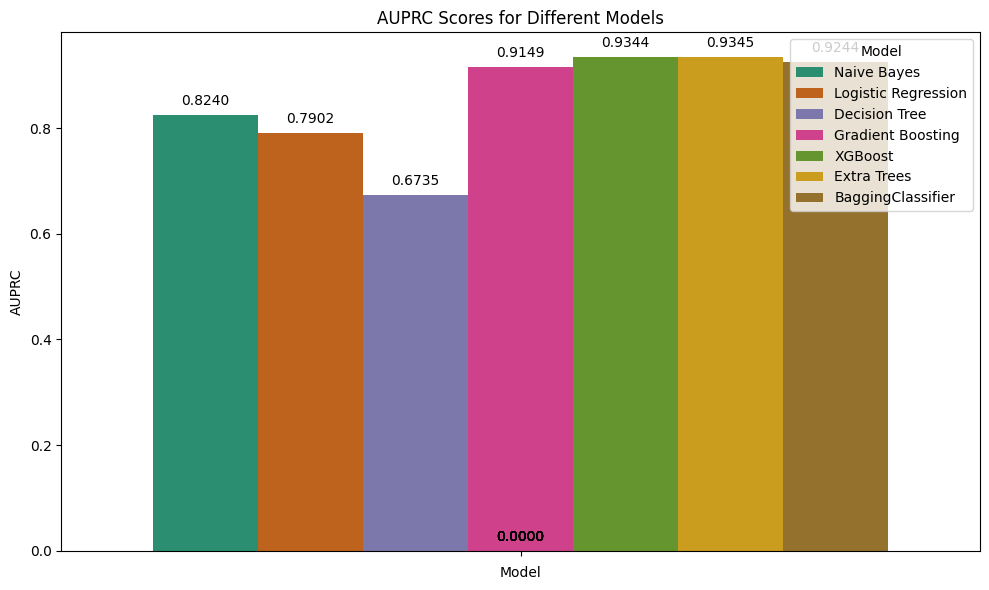

In [67]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(hue='Model', y='AUPRC', data=results_df, palette='Dark2')
plt.title('AUPRC Scores for Different Models')
plt.xlabel('Model')
plt.ylabel('AUPRC')

# Add AUPRC scores above each bar
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.4f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points')

plt.tight_layout()
plt.show()

## Model Selection & Testing

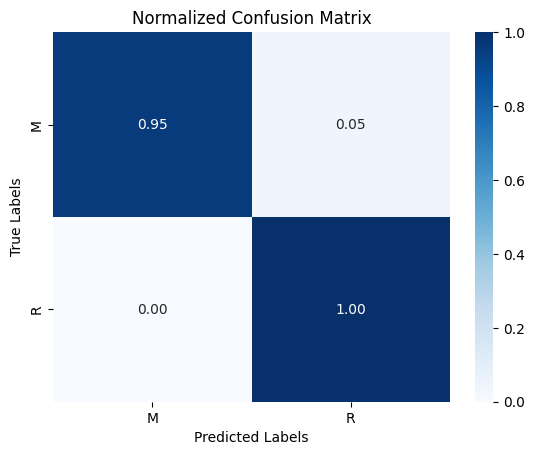

In [69]:
# Fit the best model to the entire training data
best_model = ExtraTreesClassifier(class_weight='balanced')
best_model.fit(Train_X_transformed, Train_y_transformed)

# Transform the test data
Test_X_transformed = feature_engineering_pipeline.transform(test_X)
Test_y_transformed = LabelEncoder().fit_transform(test_y)

# Predictions
y_pred = best_model.predict(Test_X_transformed)
y_proba = best_model.predict_proba(Test_X_transformed)

TARGET_NAMES = LabelEncoder().fit(train_y).classes_
#print(classification_report(Test_y_transformed, y_pred, target_names=TARGET_NAMES))

# Plot confusion matrix
# Plot normalized confusion matrix
cm = confusion_matrix(Test_y_transformed, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=TARGET_NAMES, yticklabels=TARGET_NAMES)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [72]:
# Select 10 random samples from the test data
random_indices = np.random.choice(len(Test_X_transformed), size=10, replace=False)
random_samples = Test_X_transformed[random_indices]
random_labels = Test_y_transformed[random_indices]

# Predictions
random_predictions = best_model.predict(random_samples)

# Create a DataFrame to show the original and predicted labels
prediction_comparison = pd.DataFrame({
    'Original Label': random_labels,
    'Predicted Label': random_predictions
})

# If you need to inverse transform the labels for better readability
label_encoder = LabelEncoder().fit(train_y)

# Calculate TP, FP, FN, and TN for each comparison
def label_comparison(row):
    if row['Original Label'] == row['Predicted Label'] == 1:
        return 'TP'
    elif row['Original Label'] == row['Predicted Label'] == 0:
        return 'TN'
    elif row['Original Label'] == 0 and row['Predicted Label'] == 1:
        return 'FP'
    elif row['Original Label'] == 1 and row['Predicted Label'] == 0:
        return 'FN'

prediction_comparison['Comparison'] = prediction_comparison.apply(label_comparison, axis=1)
prediction_comparison['Original Label'] = label_encoder.inverse_transform(prediction_comparison['Original Label'])
prediction_comparison['Predicted Label'] = label_encoder.inverse_transform(prediction_comparison['Predicted Label'])


prediction_comparison

Original Label Predicted Label Comparison
0              R               R         TP
1              M               M         TN
2              R               R         TP
3              R               R         TP
4              R               R         TP
5              R               R         TP
6              M               M         TN
7              R               R         TP
8              R               R         TP
9              R               R         TP